#### This file presents important parts of BMAL1 ChIP-seq preprocessing in liver, heart and kidney tissue  namely:

- Extracting all the E-box motifs CANNTG from the mouse genome using SeqIO
- Preliminary analysis of the Genome E-box, BMAL1 ChIP seq, DNase-seq and the E-box motifs.
- Extracting all E-box motifs in open chromatin using bedtools.
- Extracting bound and Unbound E-box motifs in open chromatin.
- One-hot encoding the bound and unbound E-box motifs to numerical dataset
- Analysing the bound and unbound E-box motifs.
     
     





### 1.  Extracting and processing E-box motifs from the mouse genome

In [1]:
import pandas as pd
import numpy as np
import re

import pybedtools 
import pyBigWig

from Bio import Seq

In [2]:
import matplotlib.pyplot as plt
import random
import re

In [3]:
pybedtools.helpers.set_bedtools_path(path='/mnt/home/marridan/MSU_Project/bedtools2/bin')

In [4]:
# GenomeDict is a tool that lets you get the sequences of entire chromosomes

In [5]:
import gzip

from Bio import SeqIO

class GenomeDict(object):
    def __init__(self, path_to_genome_fasta):
        # input: path_to_genome_fasta (path the the genome fast file (either .fa or .fa.gz))
        #
        # creates a dictionary of Bio.SeqRecord objects for each chromosome in the
        #
        # Warning: loads the entire genome sequence into memory at once
        #          takes a bit of time initially
        #          loads individual sequences quickly
        fasta_open = None

        if path_to_genome_fasta.endswith('.gz'):
            fasta_open = gzip.open
        else:
            fasta_open = open

        handle = fasta_open(path_to_genome_fasta, "rt")
        genome_dict = SeqIO.to_dict(SeqIO.parse(handle, 'fasta'))
        handle.close()

        self.genome_dict = genome_dict
    
    def get_sequence(self, chrom, start, end):
        return str(self.genome_dict[chrom].seq[start:end].upper())

    
# change to reference mm9 or mm10 (whichever one you're using)
genome_dict = GenomeDict('/mnt/home/marridan/MSU_Project/BMAL1_BINDING/Mus_musculus.GRCm38_newdata.fa')

In [6]:
def check_chromosome_placement(chrom_len, E_box_pos, min_distance_from_chromosome_end):
    return E_box_pos[(E_box_pos>min_distance_from_chromosome_end) & (E_box_pos<chrom_len-min_distance_from_chromosome_end)]

In [7]:
# Extracting the E-box motifs'CANNTG'. Since the motif is palindromic, we just used the forward query
forward_query = 'CA\S\STG'


In [8]:
# Adding flanking sequence upstream and downstream of the E-box motifs. let's assume you want +/- 4 nucleotides on either side of the e-box
FLANK_WIDTH = 4

In [9]:
def all_genomic_E_box(min_distance_from_chromosome_end=1500, flank_width=19):
    all_E_box = []

    # skips chromosomes that have an underscore (_) - usually unmapped or random
    # skips chromosome chrM
    # for Daniel: you might have to adapt for mouse
    for chrom in [x for x in genome_dict.genome_dict.keys() if '_' not in x and x != 'chrM']:
        print(chrom)

        # sequence for the entire chromosome
        seq = genome_dict.get_sequence(chrom, 0, None)
        chrom_len = len(seq)

        forward_E_box_pos = np.array([m.start() for m in re.finditer('(?=%s)' % forward_query, seq)])
        #reverse_complement_dre_pos = np.array([m.start() for m in re.finditer('(?=%s)' % reverse_query, seq)])

        # filters out E_box  that are too close to chromosome boundaries
        forward_E_box_pos = check_chromosome_placement(chrom_len, forward_E_box_pos, min_distance_from_chromosome_end)
        #reverse_complement_dre_pos = check_chromosome_placement(chrom_len, reverse_complement_dre_pos, min_distance_from_chromosome_end)
        
        all_E_box += [(
                chrom, E_box_pos, E_box_pos+6, 
                0, 1000, '+', 
                seq[E_box_pos-flank_width:E_box_pos+5+flank_width]) 
            for E_box_pos in forward_E_box_pos
        ]
        #all_dres += [(
        #        chrom, dre_pos, dre_pos+5, 
        #        0, 1000, '-', 
        #        str(Seq.Seq(seq[dre_pos-flank_width:dre_pos+5+flank_width]).reverse_complement())) 
        #    for dre_pos in reverse_complement_dre_pos
        #]
    
    
    all_E_box = pd.DataFrame(
        data=all_E_box, 
        columns=['chrom', 'start', 'end', 'name', 'score', 'strand', 'seq']
    ).sort_values(by=['chrom', 'start']).reset_index(drop=True)
    
    all_E_box['name'] = all_E_box.index
    return all_E_box

In [10]:
# load blacklisted regions
#  if you can find blacklisted regions for the mouse genome
#  MAKE SURE they are for the same version of genome you are using (e.g. mm9 or mm10)
blacklisted_other = pybedtools.BedTool('/mnt/home/marridan/MSU_Project/BMAL1_BINDING/mm10-blacklist.bed.gz')
blacklisted_encode = pybedtools.BedTool('/mnt/home/marridan/MSU_Project/BMAL1_BINDING/ENCFF547MET.bed.gz')
blacklisted_regions = blacklisted_encode.cat(blacklisted_other)

In [11]:
# create a dataframe of all the eboxes in the genome
all_E_box_with_strand = all_genomic_E_box()

# extracts +/- 4 e-box sequence
sequences = all_E_box_with_strand[['seq']]

# removes the sequence information from the dataframe
all_E_box_with_strand.pop('seq')

# leaves only the relevant columns
all_E_box_no_strand = all_E_box_with_strand[['chrom', 'start', 'end', 'name']]

chr10
chr11
chr12
chr13
chr14
chr15
chr16
chr17
chr18
chr19
chr1
chr2
chr3
chr4
chr5
chr6
chr7
chr8
chr9
chrX
chrY


In [12]:
# all E_box bedfile (required for genomic algebra with blacklisted regions) 

all_E_box_bed = pybedtools.BedTool.from_dataframe(all_E_box_with_strand)

In [13]:
# removes the blacklisted regions and subsets sequences 
all_E_box_with_strand_not_blacklisted = all_E_box_bed.subtract(blacklisted_regions, A=True).to_dataframe()
sequences = sequences.loc[all_E_box_with_strand_not_blacklisted['name']]

# resets the index for sequences and name column of your dres dataframe
sequences.index = all_E_box_with_strand_not_blacklisted.index
all_E_box_with_strand_not_blacklisted['name'] = all_E_box_with_strand_not_blacklisted.index


In [14]:
# save all E_Box and sequences files
#all_E_box_with_strand_not_blacklisted.to_csv('/mnt/home/marridan/MSU_Project/BMAL1_BINDING/all_genomic_E_box_not_blacklisted_with_strand.csv.gz', compression='gzip', index=False)

#sequences.to_csv('/mnt/home/marridan/MSU_Project/BMAL1_BINDING/sequences_all_genomic_E_box.csv.gz', compression='gzip', index=True)

In [15]:
#all_E_box_with_strand_not_blacklisted.to_csv('/mnt/home/marridan/MSU_Project/BMAL1_BINDING/ALL_GENOMIC_E_box_not_blacklisted_with_strand.txt', sep='\t', header=0, index = False)

In [16]:
# extract the flanking sequences and the E-box motifs.
sequences['seq'].str[FLANK_WIDTH+11:FLANK_WIDTH+15] + sequences['seq'].str[FLANK_WIDTH+15:FLANK_WIDTH+21] + sequences['seq'].str[FLANK_WIDTH+21:FLANK_WIDTH+25]

0           AACCCATCTGGTCC
1           TTTCCACTTGGTTG
2           GCCCCATATGTTTG
3           TTTCCAGGTGAATG
4           AATTCATTTGTTTC
                 ...      
14660557    TTTTCAGATGAGCT
14660558    TGCTCACTTGTATC
14660559    AGAACAGCTGACTA
14660560    AAACCACATGGATG
14660561    CCACCATGTGGTTG
Name: seq, Length: 14660562, dtype: object

In [17]:
#extract all CANNTG E-box motifs in the mouse genome
sequences['seq'].str[FLANK_WIDTH+15:FLANK_WIDTH+21].value_counts() 

CACATG    1258432
CATGTG    1257974
CATTTG    1219817
CAAATG    1216732
CATCTG    1106854
CAGATG    1102757
CAGCTG    1032960
CATATG     908460
CAGGTG     899240
CACCTG     898333
CACTTG     793471
CAAGTG     792006
CAGTTG     693089
CAACTG     693014
CAATTG     519617
CACGTG     267804
CATNTG          1
CAGNTG          1
Name: seq, dtype: int64

In [18]:
GENOME_EBOX = sequences['seq'].str[FLANK_WIDTH+15:FLANK_WIDTH+21].value_counts()
GENOME_EBOX

CACATG    1258432
CATGTG    1257974
CATTTG    1219817
CAAATG    1216732
CATCTG    1106854
CAGATG    1102757
CAGCTG    1032960
CATATG     908460
CAGGTG     899240
CACCTG     898333
CACTTG     793471
CAAGTG     792006
CAGTTG     693089
CAACTG     693014
CAATTG     519617
CACGTG     267804
CATNTG          1
CAGNTG          1
Name: seq, dtype: int64

In [19]:
#extracting the central (NN) dimer in the E-box hexamer CANNTG.
sequences['seq'].str[FLANK_WIDTH+17:FLANK_WIDTH+19].value_counts()

CA    1258432
TG    1257974
TT    1219817
AA    1216732
TC    1106854
GA    1102757
GC    1032960
TA     908460
GG     899240
CC     898333
CT     793471
AG     792006
GT     693089
AC     693014
AT     519617
CG     267804
TN          1
GN          1
Name: seq, dtype: int64

In [20]:
NEW_GENOME_EBOX = sequences['seq'].str[FLANK_WIDTH+17:FLANK_WIDTH+19].value_counts()
NEW_GENOME_EBOX

CA    1258432
TG    1257974
TT    1219817
AA    1216732
TC    1106854
GA    1102757
GC    1032960
TA     908460
GG     899240
CC     898333
CT     793471
AG     792006
GT     693089
AC     693014
AT     519617
CG     267804
TN          1
GN          1
Name: seq, dtype: int64

In [21]:
GENOME_EBOX =GENOME_EBOX.drop(GENOME_EBOX.index[[16,17]])
GENOME_EBOX

CACATG    1258432
CATGTG    1257974
CATTTG    1219817
CAAATG    1216732
CATCTG    1106854
CAGATG    1102757
CAGCTG    1032960
CATATG     908460
CAGGTG     899240
CACCTG     898333
CACTTG     793471
CAAGTG     792006
CAGTTG     693089
CAACTG     693014
CAATTG     519617
CACGTG     267804
Name: seq, dtype: int64

In [22]:
NEW_GENOME_EBOX =NEW_GENOME_EBOX.drop(NEW_GENOME_EBOX.index[[16,17]])
NEW_GENOME_EBOX

CA    1258432
TG    1257974
TT    1219817
AA    1216732
TC    1106854
GA    1102757
GC    1032960
TA     908460
GG     899240
CC     898333
CT     793471
AG     792006
GT     693089
AC     693014
AT     519617
CG     267804
Name: seq, dtype: int64

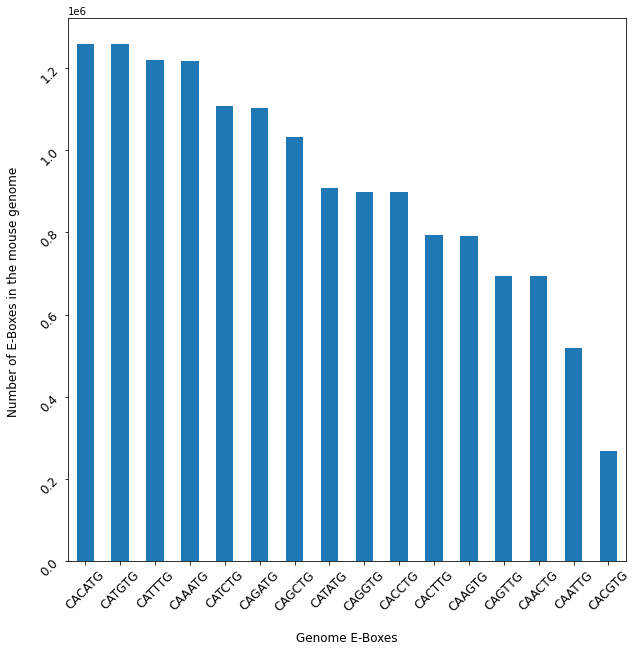

In [23]:
# Distribution of E-Box motif in the mouse genome using all the  hexamer CANNTG

fig, ax = plt.subplots(figsize=(10, 10))
ax = GENOME_EBOX .plot.bar(figsize=(10,10))
ax.set_xlabel('Genome E-Boxes',labelpad=18,fontsize='large')
ax.set_ylabel('Number of E-Boxes in the mouse genome ',labelpad=18,fontsize='large')
plt.xticks(fontsize='large', rotation =45)
plt.yticks(fontsize='large', rotation=45)
plt.savefig('MOUSE_GENOME_E-BOXES_DISTRIBUTION.png')
plt.show()

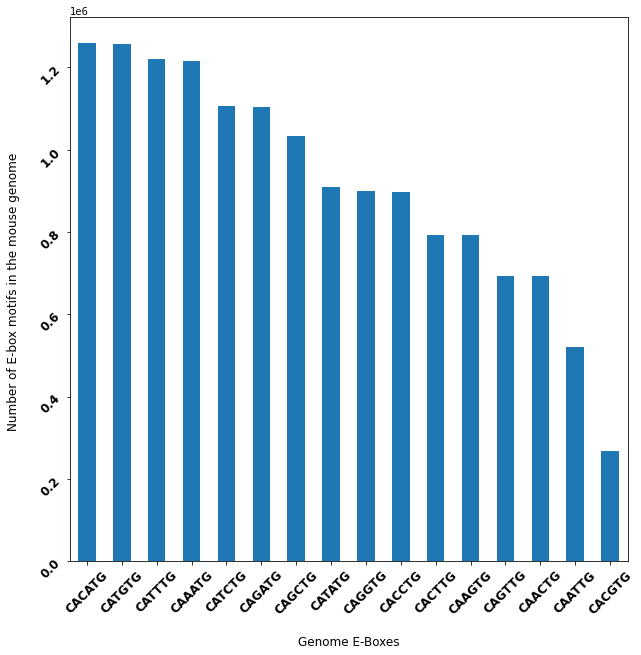

In [24]:
# Distribution of E-Box motif in the mouse genome using central (NN) dimer in the E-box hexamer CANNTG.

fig, ax = plt.subplots(figsize=(10, 10))
ax = GENOME_EBOX.plot.bar(figsize=(10,10))
ax.set_xlabel('Genome E-Boxes',labelpad=18,fontsize='large')
ax.set_ylabel('Number of E-box motifs in the mouse genome ',labelpad=18,fontsize='large')
plt.xticks(fontsize='large', rotation =45, fontweight ="bold")
plt.yticks(fontsize='large', rotation=45,fontweight ="bold")
plt.savefig('MOUSE_NEW_GENOME_E-BOXES_DISTRIBUTION.png')
plt.show()

In [25]:
GENOME_EBOX.index 

Index(['CACATG', 'CATGTG', 'CATTTG', 'CAAATG', 'CATCTG', 'CAGATG', 'CAGCTG',
       'CATATG', 'CAGGTG', 'CACCTG', 'CACTTG', 'CAAGTG', 'CAGTTG', 'CAACTG',
       'CAATTG', 'CACGTG'],
      dtype='object')

In [26]:
sequences['seq'].str[FLANK_WIDTH+17:FLANK_WIDTH+19].value_counts()

CA    1258432
TG    1257974
TT    1219817
AA    1216732
TC    1106854
GA    1102757
GC    1032960
TA     908460
GG     899240
CC     898333
CT     793471
AG     792006
GT     693089
AC     693014
AT     519617
CG     267804
TN          1
GN          1
Name: seq, dtype: int64

In [27]:
#Total number of E-box motifs in the mouse genome
sum(sequences['seq'].str[FLANK_WIDTH+17:FLANK_WIDTH+19].value_counts())

14660562

### GENOME DATA

In [28]:
# Saving the genomic E-box motifs as a bed file.
genome =  pybedtools.BedTool('Genome_E_box.bed') 

 ### 2. Analysis of tissues  BMAL1 ChIP seq, DNase-seq and the E-box motifs

### 2.1 HEART DATA

In [29]:
#HEART DATA
 
Heart_Bmal1_bound = pybedtools.BedTool('Heart_Bmal1_Dnase_intersect.bed') #Heart E-box motifs in open chromatin that intersect/overlap with the BMAL1 ChIP-seq bed file.
BMAL1_HEART_EBOX = pybedtools.BedTool('BMAL1_HEART_DNASE_EBOX_Motif.bed') # All Heart E-box motifs in open chromatin
Heart_Bmal1_unbound = pybedtools.BedTool('Heart_Bmal1_Dnase_non_intersect.bed') #Heart E-box motifs in open chromatin that donot intersect/overlap with the BMAL1 ChIP-seq bed file.

#### HEART DNASE EBOX

In [30]:
#Overlaping the heart open chromatin E-box motifs with the genome E-box motif
Heart_Dnase = BMAL1_HEART_EBOX.intersect(genome, c=True).to_dataframe()
Heart_Dnase

,chrom,start,end,name
0,chr1,3087200,3087298,2
1,chr1,3185060,3185320,3
2,chr1,3335062,3335220,2
3,chr1,3335360,3335554,1
4,chr1,3335691,3335822,2
...,...,...,...,...
157315,chrY,89263220,89263300,1
157316,chrY,90739020,90739440,3
157317,chrY,90741620,90741940,1
157318,chrY,90741620,90742340,1


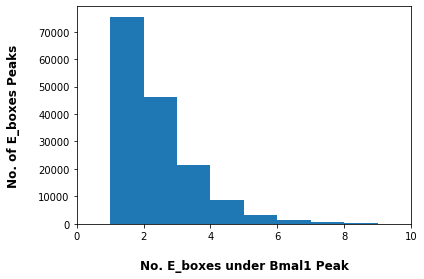

In [31]:
Count=Heart_Dnase['name']
plt.hist(Count, bins= 26)
plt.xlim([0, 10])
plt.xlabel('No. E_boxes under Bmal1 Peak',labelpad=18,fontsize='large', fontweight='bold')
plt.ylabel('No. of E_boxes Peaks',labelpad=18,fontsize='large', fontweight='bold')
#plt.savefig('Bmal_peak.png')
plt.show()

In [32]:
#Extract all Heart E-box motifs in open chromatin
Heart_Dnase_datanew=genome.intersect(BMAL1_HEART_EBOX, u=True).to_dataframe()
Heart_Dnase_datanew

,chrom,start,end,name,score,strand
0,chr1,3087234,3087240,413,1000,+
1,chr1,3087249,3087255,414,1000,+
2,chr1,3185116,3185122,940,1000,+
3,chr1,3185260,3185266,941,1000,+
4,chr1,3185291,3185297,942,1000,+
...,...,...,...,...,...,...
293923,chrY,90739138,90739144,14660248,1000,+
293924,chrY,90739245,90739251,14660249,1000,+
293925,chrY,90739262,90739268,14660250,1000,+
293926,chrY,90741826,90741832,14660255,1000,+


In [33]:
Heart_Dnase_seq = sequences.loc[Heart_Dnase_datanew['name']]


In [34]:
Heart_Dnase_seq['seq'].str[FLANK_WIDTH+15:FLANK_WIDTH+21].value_counts()

CAGCTG    38656
CACCTG    23768
CAGGTG    23653
CACATG    23567
CATGTG    23338
CATCTG    22823
CAGATG    22440
CACTTG    17023
CAAGTG    16928
CATTTG    14354
CAGTTG    14015
CAAATG    13840
CAACTG    13830
CACGTG    10595
CATATG     9385
CAATTG     5713
Name: seq, dtype: int64

In [35]:
Heart_DNAse_Count = Heart_Dnase_seq['seq'].str[FLANK_WIDTH+15:FLANK_WIDTH+21].value_counts()

In [36]:
type(Heart_DNAse_Count)

pandas.core.series.Series

In [37]:
Heart_DNAse_Count

CAGCTG    38656
CACCTG    23768
CAGGTG    23653
CACATG    23567
CATGTG    23338
CATCTG    22823
CAGATG    22440
CACTTG    17023
CAAGTG    16928
CATTTG    14354
CAGTTG    14015
CAAATG    13840
CAACTG    13830
CACGTG    10595
CATATG     9385
CAATTG     5713
Name: seq, dtype: int64

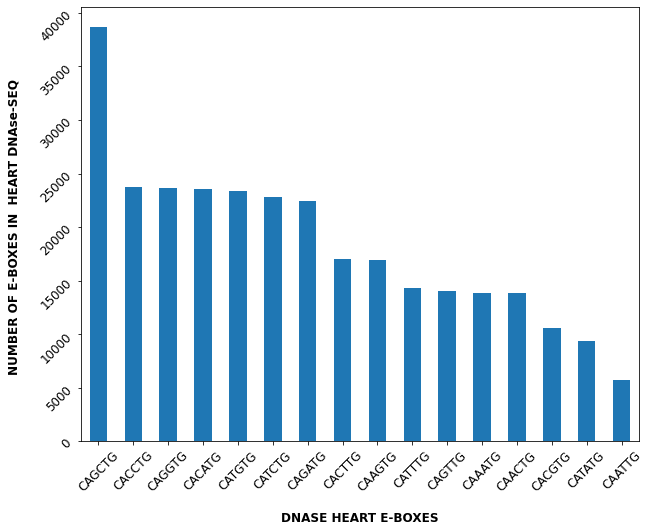

In [38]:
# Distribution of heart E-Box motifs in open chromatin using all the  hexamer CANNTG
fig, ax = plt.subplots(figsize=(10, 8))
ax = Heart_DNAse_Count.plot.bar()
ax.set_xlabel('DNASE HEART E-BOXES',labelpad=18,fontsize='large', fontweight='bold')
ax.set_ylabel('NUMBER OF E-BOXES IN  HEART DNAse-SEQ ',labelpad=18,fontsize='large', fontweight='bold')
plt.savefig('MOUSE_HEART_TISSUE_E-BOXES.png')
plt.xticks(fontsize='large', rotation =45)
plt.yticks(fontsize='large', rotation=45)
plt.show()

In [39]:
#extracting the central (NN) dimer in the E-box hexamer CANNTG .
Heart_Dnase_seq['seq'].str[FLANK_WIDTH+17:FLANK_WIDTH+19].value_counts()

GC    38656
CC    23768
GG    23653
CA    23567
TG    23338
TC    22823
GA    22440
CT    17023
AG    16928
TT    14354
GT    14015
AA    13840
AC    13830
CG    10595
TA     9385
AT     5713
Name: seq, dtype: int64

In [40]:
NEW_Heart_DNAse_Count = Heart_Dnase_seq['seq'].str[FLANK_WIDTH+17:FLANK_WIDTH+19].value_counts()
NEW_Heart_DNAse_Count

GC    38656
CC    23768
GG    23653
CA    23567
TG    23338
TC    22823
GA    22440
CT    17023
AG    16928
TT    14354
GT    14015
AA    13840
AC    13830
CG    10595
TA     9385
AT     5713
Name: seq, dtype: int64

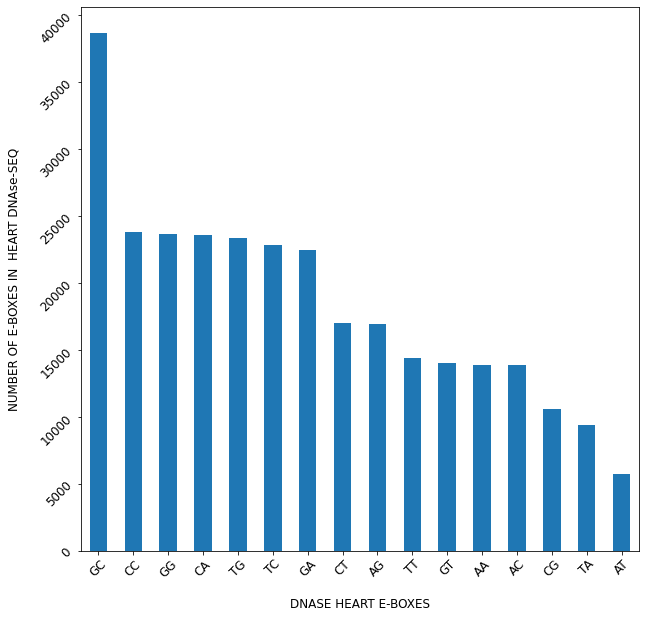

In [41]:
# Distribution of heart E-Box motifs in open chromatin using central (NN) dimer in the E-box hexamer CANNTG.
for label in (ax.get_xticklabels() + ax.get_yticklabels()):label.set_fontsize(20)
fig, ax = plt.subplots(figsize=(10, 10))
ax = NEW_Heart_DNAse_Count.plot.bar(figsize=(10,10))
ax.set_xlabel('DNASE HEART E-BOXES',labelpad=18,fontsize='large')
ax.set_ylabel('NUMBER OF E-BOXES IN  HEART DNAse-SEQ',labelpad=18,fontsize='large')
plt.xticks(fontsize='large', rotation =45)
plt.yticks(fontsize='large', rotation=45)
plt.savefig('NEW_MOUSE_HEART_TISSUE_E-BOXES.png')
plt.show()

In [42]:
# Getting all singleton E-box motifs under BMAL1 DNase peak
Heart_Single_E_box=pybedtools.BedTool.from_dataframe(Heart_Dnase[Heart_Dnase['name']==1])


In [43]:
# Getting all non-singleton E-box motifs under BMAL1 DNase peak
Heart_Non_Single_E_box =pybedtools.BedTool.from_dataframe(Heart_Dnase[Heart_Dnase['name']>1])


In [44]:
#converting the singleton bedfile into a dataframe 
Dnase_Heart_genome_with_One_E_Box = genome.intersect(Heart_Single_E_box, u=True).to_dataframe()

In [45]:
#converting the non-singleton bedfile into a dataframe
Dnase_Heart_genome_with_more_E_Box = genome.intersect(Heart_Non_Single_E_box, u=True).to_dataframe()


###  HEART BMAL1 BOUND

In [286]:
#Overlaping the heart BMAL1 chIP-seq bed file with the genome E-box motif bed file
Heart_Bmal = Heart_Bmal1_bound.intersect(genome, c=True).to_dataframe()
Heart_Bmal

,chrom,start,end,name,score,strand,thickStart
0,chr11,98783395,98783593,chr11.1,375,+,5
1,chr14,18238491,18238580,chr14.1,324,+,2
2,chr7,45707660,45707847,chr7.1,308,+,3
3,chr11,98773860,98773989,chr11.2,305,+,2
4,chr15,81810863,81810980,chr15.1,297,+,1
...,...,...,...,...,...,...,...
1045,chr4,12241009,12241178,chr4.1446,16,+,1
1046,chr8,121736460,121736540,chr8.1783,16,+,0
1047,chr10,58989780,58989911,chr10.1202,16,+,2
1048,chr11,21647680,21647782,chr11.1907,16,+,1


In [47]:
Heart_Bmal=pybedtools.BedTool.from_dataframe(Heart_Bmal)

In [48]:
#Extracting bound E-box motifs in the heart
Bound_Heart_Bmal = genome.intersect(Heart_Bmal, u=True).to_dataframe()
Heart_Positive_bed = Bound_Heart_Bmal
Heart_Positive_bed

,chrom,start,end,name,score,strand
0,chr1,36539391,36539397,179674,1000,+
1,chr1,38129865,38129871,189309,1000,+
2,chr1,52213851,52213857,265983,1000,+
3,chr1,52213927,52213933,265984,1000,+
4,chr1,52232457,52232463,266059,1000,+
...,...,...,...,...,...,...
1308,chrX,74368659,74368665,13716911,1000,+
1309,chrX,103493420,103493426,13869125,1000,+
1310,chrX,140511226,140511232,14054948,1000,+
1311,chrX,140520383,140520389,14054991,1000,+


In [49]:
# Extending the motifs to include 4 nucleotide flanking sequence upstream and downstream of the motif
Heart_Positive_bed['start'] = Heart_Positive_bed['start'] - 4
Heart_Positive_bed['end'] = Heart_Positive_bed['end'] + 4
Heart_Positive_bed

,chrom,start,end,name,score,strand
0,chr1,36539387,36539401,179674,1000,+
1,chr1,38129861,38129875,189309,1000,+
2,chr1,52213847,52213861,265983,1000,+
3,chr1,52213923,52213937,265984,1000,+
4,chr1,52232453,52232467,266059,1000,+
...,...,...,...,...,...,...
1308,chrX,74368655,74368669,13716911,1000,+
1309,chrX,103493416,103493430,13869125,1000,+
1310,chrX,140511222,140511236,14054948,1000,+
1311,chrX,140520379,140520393,14054991,1000,+


In [50]:
#Saving the bed file
Heart_Positive_bed.to_csv('/mnt/home/marridan/MSU_Project/BMAL1_BINDING/HEART_Bound_Bmal_Positive.bed', sep='\t', header=0, index = False)

In [51]:
# Extending the motifs to include 743 nucleotide flanking sequence upstream and downstream of the motif. This was used to process the histone mofification features.
Heart_Positive_bed['start'] = Heart_Positive_bed['start'] - 743
Heart_Positive_bed['end'] = Heart_Positive_bed['end'] + 743
Heart_Positive_bed

,chrom,start,end,name,score,strand
0,chr1,36538644,36540144,179674,1000,+
1,chr1,38129118,38130618,189309,1000,+
2,chr1,52213104,52214604,265983,1000,+
3,chr1,52213180,52214680,265984,1000,+
4,chr1,52231710,52233210,266059,1000,+
...,...,...,...,...,...,...
1308,chrX,74367912,74369412,13716911,1000,+
1309,chrX,103492673,103494173,13869125,1000,+
1310,chrX,140510479,140511979,14054948,1000,+
1311,chrX,140519636,140521136,14054991,1000,+


In [52]:
#Saving the bed file
Heart_Positive_bed.to_csv('/mnt/home/marridan/MSU_Project/BMAL1_BINDING/HEART_Bound_Bmal_Positive_Extract.bed', sep='\t', header=0, index = False)

In [53]:
Heart_BMAL1_Bound  = sequences.loc[Bound_Heart_Bmal['name']]


In [54]:
#extract the distribution of bound CANNTG E-box motifs in heart
Heart_BMAL1_Bound['seq'].str[FLANK_WIDTH+15:FLANK_WIDTH+21].value_counts()

CACGTG    507
CAGCTG    184
CACCTG     90
CATGTG     89
CACATG     84
CAGGTG     76
CACTTG     57
CATCTG     44
CAAGTG     41
CAGATG     36
CAACTG     29
CAGTTG     27
CAATTG     16
CAAATG     13
CATTTG     11
CATATG      9
Name: seq, dtype: int64

In [55]:
Heart_BMAL1_Bound_E_BOX = Heart_BMAL1_Bound['seq'].str[FLANK_WIDTH+15:FLANK_WIDTH+21].value_counts()

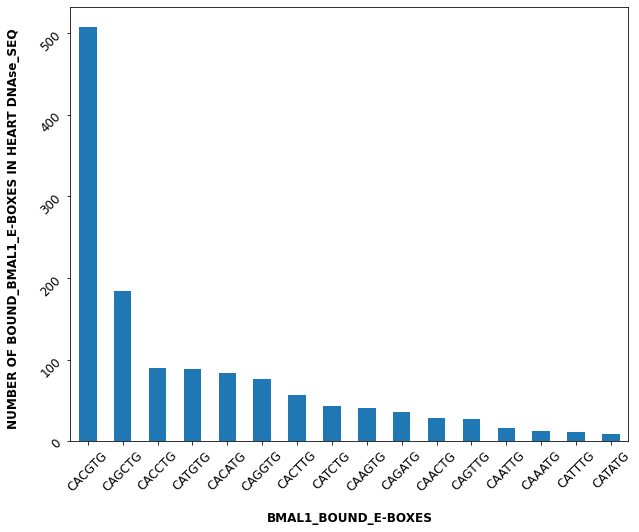

In [56]:
# Distribution of bound CANNTG E-box motifs in heart using hexamer CANNTG.
fig, ax = plt.subplots(figsize=(10, 8))
ax = Heart_BMAL1_Bound_E_BOX.plot.bar()
ax.set_xlabel('BMAL1_BOUND_E-BOXES',labelpad=18,fontsize='large', fontweight='bold')
ax.set_ylabel('NUMBER OF BOUND_BMAL1_E-BOXES IN HEART DNAse_SEQ  ',labelpad=18,fontsize='large', fontweight='bold')
plt.xticks(fontsize='large', rotation =45)
plt.yticks(fontsize='large', rotation=45)
plt.savefig('MOUSE_HEART_BOUND_E-BOXES.png')
plt.show()

In [57]:
# extract the distribution of bound CANNTG E-box motifs in heart using the central (NN) dimer
Heart_BMAL1_Bound['seq'].str[FLANK_WIDTH+17:FLANK_WIDTH+19].value_counts()

CG    507
GC    184
CC     90
TG     89
CA     84
GG     76
CT     57
TC     44
AG     41
GA     36
AC     29
GT     27
AT     16
AA     13
TT     11
TA      9
Name: seq, dtype: int64

In [58]:
NEW_Heart_BMAL1_Bound_E_BOX = Heart_BMAL1_Bound['seq'].str[FLANK_WIDTH+17:FLANK_WIDTH+19].value_counts()
NEW_Heart_BMAL1_Bound_E_BOX

CG    507
GC    184
CC     90
TG     89
CA     84
GG     76
CT     57
TC     44
AG     41
GA     36
AC     29
GT     27
AT     16
AA     13
TT     11
TA      9
Name: seq, dtype: int64

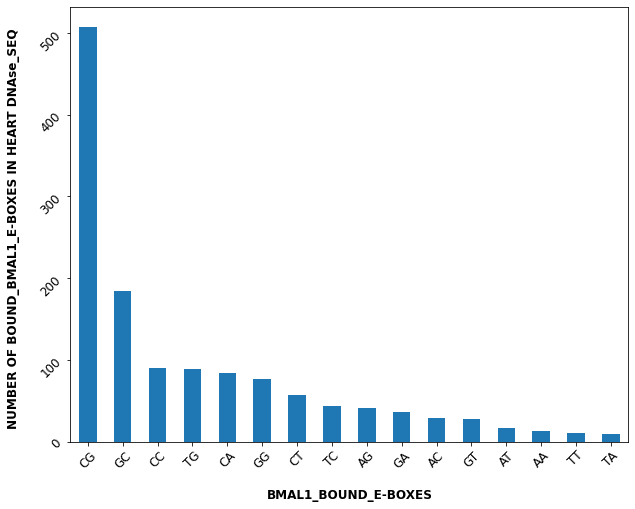

In [59]:
# Distribution of bound CANNTG E-box motifs in heart using the central (NN) dimer

fig, ax = plt.subplots(figsize=(10, 8))
ax = NEW_Heart_BMAL1_Bound_E_BOX.plot.bar()
ax.set_xlabel('BMAL1_BOUND_E-BOXES',labelpad=18,fontsize='large', fontweight='bold')
ax.set_ylabel('NUMBER OF BOUND_BMAL1_E-BOXES IN HEART DNAse_SEQ  ',labelpad=18,fontsize='large', fontweight='bold')
plt.xticks(fontsize='large', rotation =45)
plt.yticks(fontsize='large', rotation=45)
plt.savefig('NEW_MOUSE_HEART_BOUND_E-BOXES.png')
plt.show()

In [60]:
Heart_bound_e_box_seq =Heart_BMAL1_Bound['seq'].str[FLANK_WIDTH+11:FLANK_WIDTH+15] + Heart_BMAL1_Bound['seq'].str[FLANK_WIDTH+15:FLANK_WIDTH+21] + Heart_BMAL1_Bound['seq'].str[FLANK_WIDTH+21:FLANK_WIDTH+25]
Heart_bound_e_box_seq 

179674      GCCTCAGCTGGCCA
189309      GCTGCACGTGACCG
265983      AGGGCACCTGCTGA
265984      CTCCCAACTGCTAC
266059      TAATCACATGGCAC
                 ...      
13716911    CCACCACCTGGGCT
13869125    CAGTCATCTGCGGA
14054948    GAGCCATGTGCTGC
14054991    GGGCCACGTGAGGT
14054992    AGGTCAGGTGGGGC
Name: seq, Length: 1313, dtype: object

In [61]:
Heart_bound_e_box_seq.to_csv('/mnt/home/marridan/MSU_Project/BMAL1_BINDING/Positive_Heart_E_BOX_seq.txt', sep='\t', header=0, index = False)

In [62]:
##One-hot encoding the bound liver E-box motifs and the flanking sequence

In [63]:
Pos_Heart_E_box = pd.read_csv('Positive_Heart_E_BOX_seq.txt', header = None)

In [64]:
Pos_Heart=Pos_Heart_E_box.loc[:,0].values
Pos_Heart

array(['GCCTCAGCTGGCCA', 'GCTGCACGTGACCG', 'AGGGCACCTGCTGA', ...,
       'GAGCCATGTGCTGC', 'GGGCCACGTGAGGT', 'AGGTCAGGTGGGGC'], dtype=object)

In [65]:
import numpy as np
from numpy import array
from numpy import argmax
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

In [66]:
# defining the values to be used. If not defined, normal 26 alphabet length might be used by program
alphabet = 'ACGT'

In [67]:
# defining a mapping of characters to integers
char_to_int = dict((c, i) for i, c in enumerate(alphabet))
int_to_char = dict((i, c) for i, c in enumerate(alphabet))

In [68]:
#declaring variable to hold the encoded data
onehot_encoded = list()
# looping through each item in the list containing strings
for i in Pos_Heart:
    integer_encoded = [char_to_int[char] for char in i]
    #print(integer_encoded)
    # one hot encode; variable to hold each character which would be encoded
    onehot_encoded2 = list()
    # integer encode input data
    for value in integer_encoded:
    	letter = [0 for _ in range(len(alphabet))]
    	letter[value] = 1
    	onehot_encoded2.extend(letter)
        #onehot_encoded.extend(letter)
        #onehot_encoded2=onehot_encoded
    onehot_encoded.append(onehot_encoded2)

In [69]:
Pos_heart_One_hot=np.asarray( onehot_encoded)
Pos_heart_One_hot

array([[0, 0, 1, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 1, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 1, ..., 1, 0, 0],
       [0, 0, 1, ..., 0, 0, 1],
       [1, 0, 0, ..., 1, 0, 0]])

In [70]:
Pos_heart_One_hot.shape

(1313, 56)

In [71]:
#Save the encoded dataset
np.savetxt("Positive_heart_One_hot.csv", Pos_heart_One_hot, delimiter=",")

### HEART UNBOUND

In [72]:
#Overlaping the heart unbound motif bed file with the genome E-box motif bed file

Heart_Bmal_not_bound_new = Heart_Bmal1_unbound.intersect(genome, c=True).to_dataframe()


In [73]:
Heart_Bmal_not_bound =pybedtools.BedTool.from_dataframe(Heart_Bmal_not_bound_new)

In [74]:
# Getting the unbound e-box motifs in heart open chromatin
Un_Bound_Heart_Bmal = genome.intersect(Heart_Bmal_not_bound, u=True).to_dataframe()
Un_bound_Heart =Un_Bound_Heart_Bmal 
Un_bound_Heart

,chrom,start,end,name,score,strand
0,chr1,3087234,3087240,413,1000,+
1,chr1,3087249,3087255,414,1000,+
2,chr1,3185116,3185122,940,1000,+
3,chr1,3185260,3185266,941,1000,+
4,chr1,3185291,3185297,942,1000,+
...,...,...,...,...,...,...
291835,chrY,90739138,90739144,14660248,1000,+
291836,chrY,90739245,90739251,14660249,1000,+
291837,chrY,90739262,90739268,14660250,1000,+
291838,chrY,90741826,90741832,14660255,1000,+


In [75]:
# Extending the motifs to include 4 nucleotide flanking sequence upstream and downstream of the motif
Un_bound_Heart['start'] = Un_bound_Heart['start'] - 4
Un_bound_Heart['end'] = Un_bound_Heart['end'] + 4
Un_bound_Heart

,chrom,start,end,name,score,strand
0,chr1,3087230,3087244,413,1000,+
1,chr1,3087245,3087259,414,1000,+
2,chr1,3185112,3185126,940,1000,+
3,chr1,3185256,3185270,941,1000,+
4,chr1,3185287,3185301,942,1000,+
...,...,...,...,...,...,...
291835,chrY,90739134,90739148,14660248,1000,+
291836,chrY,90739241,90739255,14660249,1000,+
291837,chrY,90739258,90739272,14660250,1000,+
291838,chrY,90741822,90741836,14660255,1000,+


In [76]:
#Saving the dataset
Un_bound_Heart.to_csv('/mnt/home/marridan/MSU_Project/BMAL1_BINDING/HEART_UnBound_Bmal_Negative.bed', sep='\t', header=0, index = False)

In [77]:
# Extending the motifs to include 743 nucleotide flanking sequence upstream and downstream of the motif. This was used to process the histone mofification features.
Un_bound_Heart['start'] = Un_bound_Heart['start'] - 743
Un_bound_Heart['end'] = Un_bound_Heart['end'] + 743
Un_bound_Heart

,chrom,start,end,name,score,strand
0,chr1,3086487,3087987,413,1000,+
1,chr1,3086502,3088002,414,1000,+
2,chr1,3184369,3185869,940,1000,+
3,chr1,3184513,3186013,941,1000,+
4,chr1,3184544,3186044,942,1000,+
...,...,...,...,...,...,...
291835,chrY,90738391,90739891,14660248,1000,+
291836,chrY,90738498,90739998,14660249,1000,+
291837,chrY,90738515,90740015,14660250,1000,+
291838,chrY,90741079,90742579,14660255,1000,+


In [78]:
# Saving the dataset
Un_bound_Heart.to_csv('/mnt/home/marridan/MSU_Project/BMAL1_BINDING/HEART_UnBound_Bmal_Negative_Extract.bed', sep='\t', header=0, index = False)

In [79]:
Heart_BMAL1__NOT_Bound  = sequences.loc[Un_Bound_Heart_Bmal['name']]


In [80]:
#extract the distribution of unbound CANNTG E-box motifs in heart
Heart_BMAL1__NOT_Bound['seq'].str[FLANK_WIDTH+15:FLANK_WIDTH+21].value_counts()

CAGCTG    38333
CACCTG    23602
CAGGTG    23496
CACATG    23454
CATGTG    23201
CATCTG    22724
CAGATG    22360
CACTTG    16919
CAAGTG    16835
CATTTG    14325
CAGTTG    13953
CAAATG    13808
CAACTG    13756
CACGTG    10025
CATATG     9365
CAATTG     5684
Name: seq, dtype: int64

In [81]:
Heart_BMAL1_NOT_Bound_E_BOX = Heart_BMAL1__NOT_Bound['seq'].str[FLANK_WIDTH+15:FLANK_WIDTH+21].value_counts()

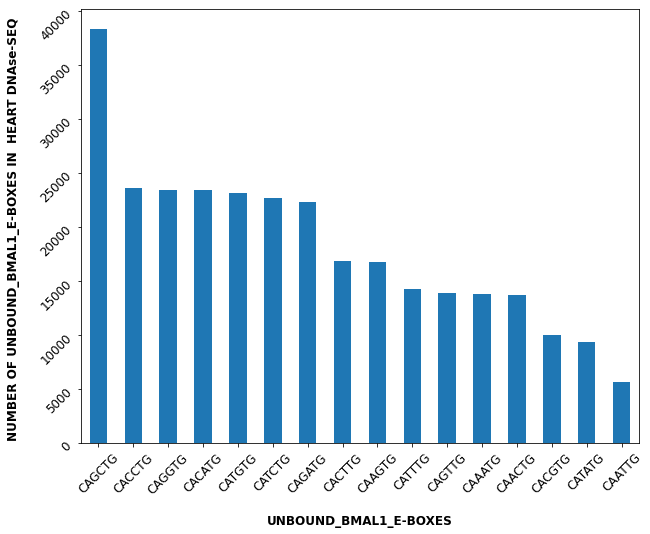

In [82]:
# Distribution of unbound CANNTG E-box motifs in heart using the hexamer

fig, ax = plt.subplots(figsize=(10, 8))
ax = Heart_BMAL1_NOT_Bound_E_BOX.plot.bar()
ax.set_xlabel('UNBOUND_BMAL1_E-BOXES',labelpad=18,fontsize='large', fontweight='bold')
ax.set_ylabel('NUMBER OF UNBOUND_BMAL1_E-BOXES IN  HEART DNAse-SEQ ',labelpad=18,fontsize='large', fontweight='bold')
plt.xticks(fontsize='large', rotation =45)
plt.yticks(fontsize='large', rotation=45)
plt.savefig('MOUSE_HEART_UNBOUND_E-BOXES.png')
plt.show()

In [83]:
Heart_BMAL1_NOT_Bound_E_BOX_seq = Heart_BMAL1__NOT_Bound['seq'].str[FLANK_WIDTH+11:FLANK_WIDTH+15] + Heart_BMAL1__NOT_Bound['seq'].str[FLANK_WIDTH+15:FLANK_WIDTH+21] + Heart_BMAL1__NOT_Bound['seq'].str[FLANK_WIDTH+21:FLANK_WIDTH+25]
Heart_BMAL1_NOT_Bound_E_BOX_seq 

413         CCAACATCTGCTAC
414         TATACAGCTGGAGC
940         TCTGCATGTGGGAT
941         GCTCCAGATGGGCC
942         ACCCCATATGGTGG
                 ...      
14660248    TTTCCAGGTGCGCG
14660249    ATTGCAGTTGAAAT
14660250    TATGCAAATGTGTG
14660255    TGCACAGGTGGTGG
14660256    GGTGCACTTGCGTG
Name: seq, Length: 291840, dtype: object

In [84]:
Heart_BMAL1_NOT_Bound_E_BOX_seq.to_csv('/mnt/home/marridan/MSU_Project/BMAL1_BINDING/Negative_Heart_E_BOX_seq.txt', sep='\t', header=0, index = False)

In [85]:
##One-hot encoding the unbound liver E-box motifs and the flanking sequence

In [86]:
Neg_Heart_E_box = pd.read_csv('Negative_Heart_E_BOX_seq.txt', header = None)

In [87]:
Neg_Heart=Neg_Heart_E_box.loc[:,0].values
Neg_Heart

array(['CCAACATCTGCTAC', 'TATACAGCTGGAGC', 'TCTGCATGTGGGAT', ...,
       'TATGCAAATGTGTG', 'TGCACAGGTGGTGG', 'GGTGCACTTGCGTG'], dtype=object)

In [88]:
import numpy as np
from numpy import array
from numpy import argmax
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

In [89]:
# defining the values to be used. If not defined, normal 26 alphabet length might be used by program
alphabet = 'ACGT'

In [90]:
# defining a mapping of characters to integers
char_to_int = dict((c, i) for i, c in enumerate(alphabet))
int_to_char = dict((i, c) for i, c in enumerate(alphabet))

In [91]:
#declaring variable to hold the encoded data
onehot_encoded = list()
# looping through each item in the list containing strings
for i in Neg_Heart:
    integer_encoded = [char_to_int[char] for char in i]
    #print(integer_encoded)
    # one hot encode; variable to hold each character which would be encoded
    onehot_encoded2 = list()
    # integer encode input data
    for value in integer_encoded:
    	letter = [0 for _ in range(len(alphabet))]
    	letter[value] = 1
    	onehot_encoded2.extend(letter)
        #onehot_encoded.extend(letter)
        #onehot_encoded2=onehot_encoded
    onehot_encoded.append(onehot_encoded2)

In [92]:
Neg_heart_One_hot=np.asarray( onehot_encoded)
Neg_heart_One_hot

array([[0, 1, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 0, 1],
       ...,
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 1, ..., 0, 1, 0]])

In [93]:
Neg_heart_One_hot.shape

(291840, 56)

In [94]:
#Save the encoded dataset
np.savetxt("Negative_heart_One_hot.csv", Neg_heart_One_hot, delimiter=",")

### 2.2  KIDNEY DATA

In [96]:
#Importing the all genome and the DNase dataset dataset
BMAL1_KIDNEY_DNASE_EBOX = pybedtools.BedTool('BMAL1_KIDNEY_DNASE_EBOX_Motif.bed')  # All Kidney E-box motifs in open chromatin
Kidney_chip_Dnase = pybedtools.BedTool('Kidney_Chip_Dnase_Intersect.bed')  #Heart E-box motifs in open chromatin that intersect/overlap with the BMAL1 ChIP-seq bed file.
Kidney_chip_non_Dnase = pybedtools.BedTool('Kidney_Chip_Dnase_non_Intersect.bed') #Heart E-box motifs in open chromatin that donot intersect/overlap with the BMAL1 ChIP-seq bed file.

#### KIDNEY DNASE EBOX

In [97]:
#Overlaping the heart open chromatin E-box motifs with the genome E-box motif
Kidney_Dnase = BMAL1_KIDNEY_DNASE_EBOX.intersect(genome, c=True).to_dataframe()
Kidney_Dnase

,chrom,start,end,name
0,chr1,3116840,3117060,2
1,chr1,3119596,3119786,2
2,chr1,3119920,3120180,1
3,chr1,3120400,3120600,1
4,chr1,3121400,3121620,1
...,...,...,...,...
154098,chrY,9837363,9837416,1
154099,chrY,90726180,90726340,1
154100,chrY,90734420,90734600,1
154101,chrY,90739029,90739420,3


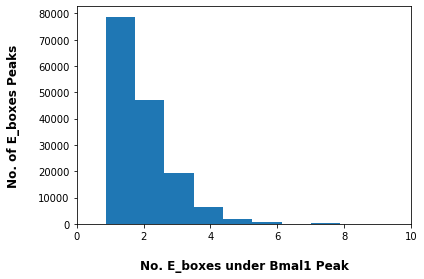

In [98]:
Count=Kidney_Dnase['name']
plt.hist(Count, bins= 16)
plt.xlim([0, 10])
plt.xlabel('No. E_boxes under Bmal1 Peak',labelpad=18,fontsize='large', fontweight='bold')
plt.ylabel('No. of E_boxes Peaks',labelpad=18,fontsize='large', fontweight='bold')
#plt.savefig('Bmal_peak.png')
plt.show()

In [99]:
#Extract all Kidney E-box motifs in open chromatin
Kidney_Dnase_datanew=genome.intersect(BMAL1_KIDNEY_DNASE_EBOX, u=True).to_dataframe()
Kidney_Dnase_datanew

,chrom,start,end,name,score,strand
0,chr1,3116879,3116885,564,1000,+
1,chr1,3117020,3117026,565,1000,+
2,chr1,3119753,3119759,577,1000,+
3,chr1,3119773,3119779,578,1000,+
4,chr1,3120113,3120119,580,1000,+
...,...,...,...,...,...,...
268685,chrY,90734488,90734494,14660245,1000,+
268686,chrY,90739138,90739144,14660248,1000,+
268687,chrY,90739245,90739251,14660249,1000,+
268688,chrY,90739262,90739268,14660250,1000,+


In [100]:
Kidney_Dnase_seq = sequences.loc[Kidney_Dnase_datanew['name']]


In [101]:
Kidney_Dnase_seq['seq'].str[FLANK_WIDTH+15:FLANK_WIDTH+21].value_counts()

CAGCTG    38039
CATGTG    19149
CACATG    18970
CATCTG    18780
CAGATG    18531
CACCTG    18108
CAGGTG    18015
CATTTG    17300
CAAATG    17225
CACTTG    16842
CAAGTG    16552
CAGTTG    14084
CAACTG    14017
CACGTG    11461
CAATTG     6202
CATATG     5415
Name: seq, dtype: int64

In [102]:
Kidney_DNAse_Count = Kidney_Dnase_seq['seq'].str[FLANK_WIDTH+15:FLANK_WIDTH+21].value_counts()

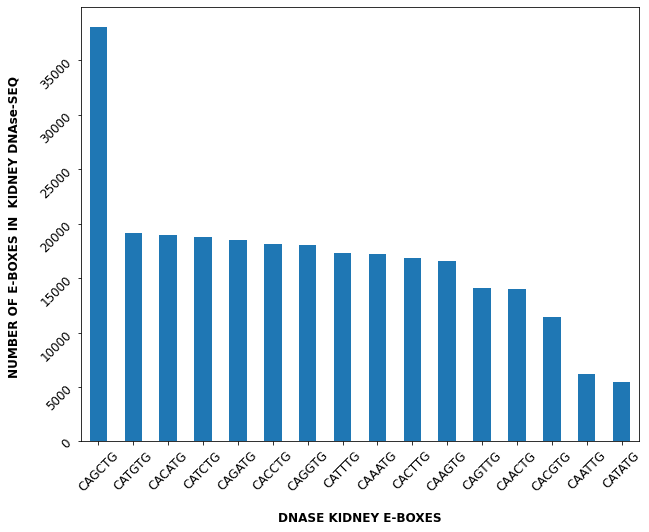

In [104]:
# Distribution of heart E-Box motifs in open chromatin using all the  hexamer CANNTG
fig, ax = plt.subplots(figsize=(10, 8))
ax = Kidney_DNAse_Count.plot.bar()
ax.set_xlabel('DNASE KIDNEY E-BOXES',labelpad=18,fontsize='large', fontweight='bold')
ax.set_ylabel('NUMBER OF E-BOXES IN  KIDNEY DNAse-SEQ ',labelpad=18,fontsize='large', fontweight='bold')
plt.xticks(fontsize='large', rotation =45)
plt.yticks(fontsize='large', rotation=45)
plt.savefig('MOUSE_KIDNEY_TISSUE_E-BOXES.png')
plt.show()

In [105]:
#extracting the central (NN) dimer in the E-box hexamer CANNTG .
Kidney_Dnase_seq['seq'].str[FLANK_WIDTH+17:FLANK_WIDTH+19].value_counts()

GC    38039
TG    19149
CA    18970
TC    18780
GA    18531
CC    18108
GG    18015
TT    17300
AA    17225
CT    16842
AG    16552
GT    14084
AC    14017
CG    11461
AT     6202
TA     5415
Name: seq, dtype: int64

In [106]:
NEW_Kidney_DNAse_Count = Kidney_Dnase_seq['seq'].str[FLANK_WIDTH+17:FLANK_WIDTH+19].value_counts()
NEW_Kidney_DNAse_Count

GC    38039
TG    19149
CA    18970
TC    18780
GA    18531
CC    18108
GG    18015
TT    17300
AA    17225
CT    16842
AG    16552
GT    14084
AC    14017
CG    11461
AT     6202
TA     5415
Name: seq, dtype: int64

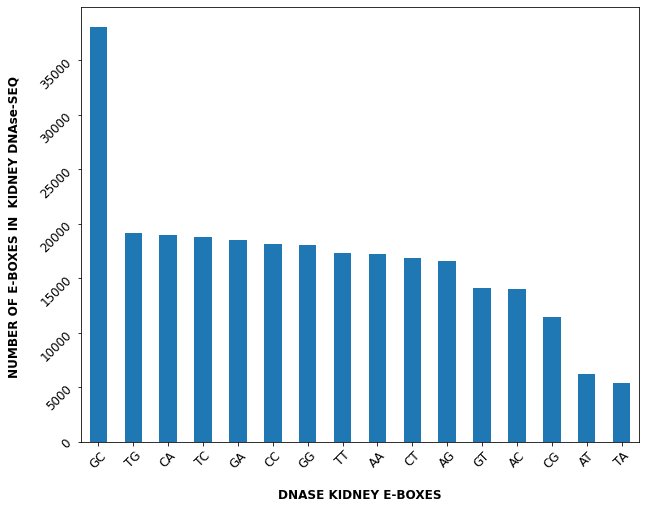

In [107]:
# Distribution of heart E-Box motifs in open chromatin using central (NN) dimer in the E-box hexamer CANNTG.
fig, ax = plt.subplots(figsize=(10, 8))
ax = NEW_Kidney_DNAse_Count.plot.bar()
ax.set_xlabel('DNASE KIDNEY E-BOXES',labelpad=18,fontsize='large', fontweight='bold')
ax.set_ylabel('NUMBER OF E-BOXES IN  KIDNEY DNAse-SEQ ',labelpad=18,fontsize='large', fontweight='bold')
plt.xticks(fontsize='large', rotation =45)
plt.yticks(fontsize='large', rotation=45)
plt.savefig('NEW_MOUSE_KIDNEY_TISSUE_E-BOXES.png')
plt.show()

### KIDNEY BOUND

In [280]:
#Overlaping the Kidney BMAL1 chIP-seq bed file with the genome E-box motif bed file
Kidney_Bound =Kidney_chip_Dnase.intersect(genome, c=True).to_dataframe()
Kidney_Bound

,chrom,start,end,name,score,strand,thickStart
0,chr11,98783397,98783585,chr11.1,304,+,5
1,chr14,18238497,18238540,chr14.1,301,+,1
2,chr7,45707664,45707852,chr7.1,285,+,2
3,chr11,98773820,98773966,chr11.2,290,+,3
4,chr15,81810883,81811071,chr15.1,277,+,3
...,...,...,...,...,...,...,...
3074,chr17,28682741,28682929,chr17.439,14,+,2
3075,chr18,39467051,39467239,chr18.226,14,+,1
3076,chr18,80151061,80151180,chr18.249,14,+,1
3077,chr19,11770352,11770460,chr19.329,14,+,0


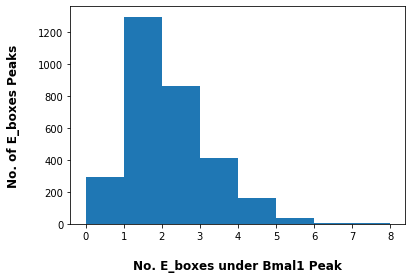

In [109]:
Count = Kidney_Bound['thickStart']
plt.hist(Count, bins= 8)
plt.xlabel('No. E_boxes under Bmal1 Peak',labelpad=18,fontsize='large', fontweight='bold')
plt.ylabel('No. of E_boxes Peaks',labelpad=18,fontsize='large', fontweight='bold')
#plt.savefig('Bmal_peak.png')
plt.show()

In [110]:
Kidney_Bound=pybedtools.BedTool.from_dataframe(Kidney_Bound)

In [111]:
#Extracting bound E-box motifs in the Kidney
Kidney_Bound_Bmal = genome.intersect(Kidney_Bound, u=True).to_dataframe()
Kidney_Bound_Bmal

,chrom,start,end,name,score,strand
0,chr1,5083030,5083036,11071,1000,+
1,chr1,5083078,5083084,11072,1000,+
2,chr1,5083088,5083094,11073,1000,+
3,chr1,5083102,5083108,11074,1000,+
4,chr1,9848192,9848198,36041,1000,+
...,...,...,...,...,...,...
5145,chrX,153139954,153139960,14121080,1000,+
5146,chrX,160137607,160137613,14158780,1000,+
5147,chrX,160137618,160137624,14158781,1000,+
5148,chrX,160137630,160137636,14158782,1000,+


In [112]:
Kidney_BMAL1_Bound  = sequences.loc[Kidney_Bound_Bmal['name']]


In [113]:
Kidney_BMAL1_Bound['seq'].str[FLANK_WIDTH+15:FLANK_WIDTH+21].value_counts()

CACGTG    1684
CAGCTG     557
CATGTG     477
CACATG     459
CAGGTG     431
CACCTG     402
CACTTG     169
CATCTG     164
CAAGTG     149
CAGATG     147
CAACTG     125
CAGTTG     121
CATTTG      96
CAAATG      91
CAATTG      53
CATATG      25
Name: seq, dtype: int64

In [114]:
Kidney_BMAL1_Bound_E_BOX = Kidney_BMAL1_Bound['seq'].str[FLANK_WIDTH+15:FLANK_WIDTH+21].value_counts()

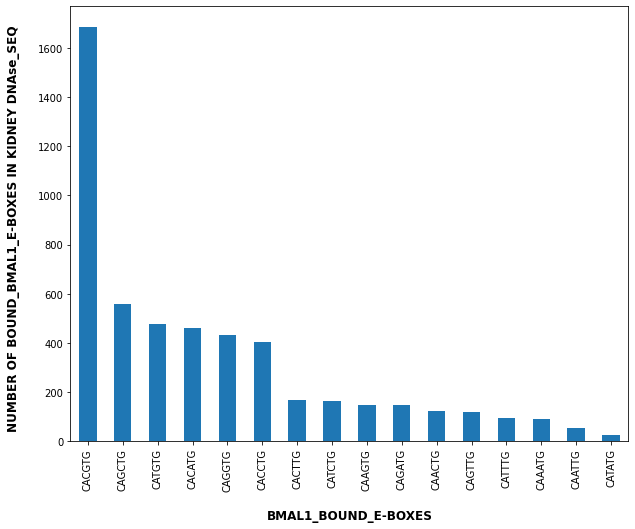

In [116]:
# Distribution of bound CANNTG E-box motifs in Kidney using hexamer CANNTG.
fig, ax = plt.subplots(figsize=(10, 8))
ax = Kidney_BMAL1_Bound_E_BOX.plot.bar()
ax.set_xlabel('BMAL1_BOUND_E-BOXES',labelpad=18,fontsize='large', fontweight='bold')
ax.set_ylabel('NUMBER OF BOUND_BMAL1_E-BOXES IN KIDNEY DNAse_SEQ  ',labelpad=18,fontsize='large', fontweight='bold')
plt.savefig('MOUSE_KIDNEY_BOUND_E-BOXES.png')
plt.show()

In [117]:
Kidney_BMAL1_Bound['seq'].str[FLANK_WIDTH+17:FLANK_WIDTH+19].value_counts()

CG    1684
GC     557
TG     477
CA     459
GG     431
CC     402
CT     169
TC     164
AG     149
GA     147
AC     125
GT     121
TT      96
AA      91
AT      53
TA      25
Name: seq, dtype: int64

In [118]:
NEW_Kidney_BMAL1_Bound_E_BOX = Kidney_BMAL1_Bound['seq'].str[FLANK_WIDTH+17:FLANK_WIDTH+19].value_counts()

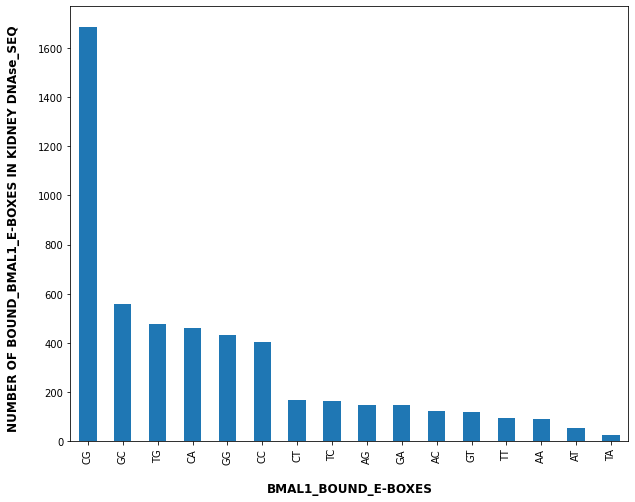

In [119]:
fig, ax = plt.subplots(figsize=(10, 8))
ax = NEW_Kidney_BMAL1_Bound_E_BOX.plot.bar()
ax.set_xlabel('BMAL1_BOUND_E-BOXES',labelpad=18,fontsize='large', fontweight='bold')
ax.set_ylabel('NUMBER OF BOUND_BMAL1_E-BOXES IN KIDNEY DNAse_SEQ  ',labelpad=18,fontsize='large', fontweight='bold')
plt.savefig('NEW_MOUSE_KIDNEY_BOUND_E-BOXES.png')
plt.show()

### GETTING THE BOUNDED 

### Getting the singleton bound motifs

In [120]:
Kidney_Bound = Kidney_Bound.to_dataframe()

In [121]:
Singleton_Kidney_bound = pybedtools.BedTool.from_dataframe(Kidney_Bound[Kidney_Bound['thickStart']==1])
Singleton_Kidney_bound.to_dataframe()

,chrom,start,end,name,score,strand,thickStart
0,chr14,18238497,18238540,chr14.1,301,+,1
1,chr11,90417980,90418168,chr11.3,258,+,1
2,chr11,98775300,98775458,chr11.5,245,+,1
3,chr9,66511740,66511928,chr9.2,249,+,1
4,chr7,45704924,45705100,chr7.2,238,+,1
...,...,...,...,...,...,...,...
1294,chr15,80795160,80795273,chr15.434,14,+,1
1295,chr15,97881500,97881637,chr15.394,15,+,1
1296,chr18,39467051,39467239,chr18.226,14,+,1
1297,chr18,80151061,80151180,chr18.249,14,+,1


In [122]:
Singleton_Kidney_bound = genome.intersect(Singleton_Kidney_bound , u=True).to_dataframe()
Singleton_Kidney_bound

,chrom,start,end,name,score,strand
0,chr1,23383368,23383374,109628,1000,+
1,chr1,23922458,23922464,112538,1000,+
2,chr1,30950182,30950188,148166,1000,+
3,chr1,35727529,35727535,174742,1000,+
4,chr1,38129865,38129871,189309,1000,+
...,...,...,...,...,...,...
1292,chrX,77433608,77433614,13733823,1000,+
1293,chrX,77509398,77509404,13734275,1000,+
1294,chrX,103493420,103493426,13869125,1000,+
1295,chrX,106027136,106027142,13882687,1000,+




### Getting the non-singleton

In [123]:
Non_Singleton_Kidney_bound = pybedtools.BedTool.from_dataframe(Kidney_Bound[Kidney_Bound['thickStart']>1])
Non_Singleton_Kidney_bound.to_dataframe()

,chrom,start,end,name,score,strand,thickStart
0,chr11,98783397,98783585,chr11.1,304,+,5
1,chr7,45707664,45707852,chr7.1,285,+,2
2,chr11,98773820,98773966,chr11.2,290,+,3
3,chr15,81810883,81811071,chr15.1,277,+,3
4,chr11,69094804,69094992,chr11.4,254,+,2
...,...,...,...,...,...,...,...
1481,chr10,20600160,20600276,chr10.482,14,+,2
1482,chr11,70054260,70054440,chr11.938,14,+,2
1483,chr14,65050600,65050779,chr14.344,14,+,2
1484,chr15,28019796,28019980,chr15.409,14,+,4


In [124]:
Non_Singleton_Kidney_bound = genome.intersect(Non_Singleton_Kidney_bound , u=True).to_dataframe()
Non_Singleton_Kidney_bound

,chrom,start,end,name,score,strand
0,chr1,5083030,5083036,11071,1000,+
1,chr1,5083078,5083084,11072,1000,+
2,chr1,5083088,5083094,11073,1000,+
3,chr1,5083102,5083108,11074,1000,+
4,chr1,9848192,9848198,36041,1000,+
...,...,...,...,...,...,...
3849,chrX,153139954,153139960,14121080,1000,+
3850,chrX,160137607,160137613,14158780,1000,+
3851,chrX,160137618,160137624,14158781,1000,+
3852,chrX,160137630,160137636,14158782,1000,+


In [125]:
Kidney_New = Non_Singleton_Kidney_bound[Non_Singleton_Kidney_bound['name']%2!=0] 
Kidney_New

,chrom,start,end,name,score,strand
0,chr1,5083030,5083036,11071,1000,+
2,chr1,5083088,5083094,11073,1000,+
4,chr1,9848192,9848198,36041,1000,+
7,chr1,10993463,10993469,42307,1000,+
9,chr1,13314190,13314196,55045,1000,+
...,...,...,...,...,...,...
3844,chrX,139808354,139808360,14051189,1000,+
3845,chrX,140520383,140520389,14054991,1000,+
3848,chrX,153139921,153139927,14121079,1000,+
3851,chrX,160137618,160137624,14158781,1000,+


In [126]:
#Combining the singleton and non singleton E-box motifs
Kidney_Positive_bed = pd.concat([Singleton_Kidney_bound,Kidney_New],ignore_index=True)
Kidney_Positive_bed

,chrom,start,end,name,score,strand
0,chr1,23383368,23383374,109628,1000,+
1,chr1,23922458,23922464,112538,1000,+
2,chr1,30950182,30950188,148166,1000,+
3,chr1,35727529,35727535,174742,1000,+
4,chr1,38129865,38129871,189309,1000,+
...,...,...,...,...,...,...
3232,chrX,139808354,139808360,14051189,1000,+
3233,chrX,140520383,140520389,14054991,1000,+
3234,chrX,153139921,153139927,14121079,1000,+
3235,chrX,160137618,160137624,14158781,1000,+


In [127]:
# Extending the motifs to include 4 nucleotide flanking sequence upstream and downstream of the motif
Kidney_Positive_bed['start'] = Kidney_Positive_bed['start'] - 4
Kidney_Positive_bed['end'] = Kidney_Positive_bed['end'] + 4
Kidney_Positive_bed

,chrom,start,end,name,score,strand
0,chr1,23383364,23383378,109628,1000,+
1,chr1,23922454,23922468,112538,1000,+
2,chr1,30950178,30950192,148166,1000,+
3,chr1,35727525,35727539,174742,1000,+
4,chr1,38129861,38129875,189309,1000,+
...,...,...,...,...,...,...
3232,chrX,139808350,139808364,14051189,1000,+
3233,chrX,140520379,140520393,14054991,1000,+
3234,chrX,153139917,153139931,14121079,1000,+
3235,chrX,160137614,160137628,14158781,1000,+


In [128]:
#Saving the the bed file
Kidney_Positive_bed.to_csv('/mnt/home/marridan/MSU_Project/BMAL1_BINDING/KIDNEY_Bound_Bmal_Positive.bed', sep='\t', header=0, index = False)

In [129]:
# Extending the motifs to include 743 nucleotide flanking sequence upstream and downstream of the motif
Kidney_Positive_bed['start'] = Kidney_Positive_bed['start'] - 743
Kidney_Positive_bed['end'] = Kidney_Positive_bed['end'] + 743
Kidney_Positive_bed

,chrom,start,end,name,score,strand
0,chr1,23382621,23384121,109628,1000,+
1,chr1,23921711,23923211,112538,1000,+
2,chr1,30949435,30950935,148166,1000,+
3,chr1,35726782,35728282,174742,1000,+
4,chr1,38129118,38130618,189309,1000,+
...,...,...,...,...,...,...
3232,chrX,139807607,139809107,14051189,1000,+
3233,chrX,140519636,140521136,14054991,1000,+
3234,chrX,153139174,153140674,14121079,1000,+
3235,chrX,160136871,160138371,14158781,1000,+


In [131]:
#Saving the file
Kidney_Positive_bed.to_csv('/mnt/home/marridan/MSU_Project/BMAL1_BINDING/KIDNEY_Bound_Bmal_Positive_Extract.bed', sep='\t', header=0, index = False)

In [132]:
Kidney_Positive_bed_Seq = sequences.loc[Kidney_Positive_bed['name']]


In [133]:
Kidney_Positive_bed_Seq['seq'].str[FLANK_WIDTH+15:FLANK_WIDTH+21].value_counts()

CACGTG    1143
CAGCTG     321
CACATG     289
CATGTG     274
CAGGTG     272
CACCTG     261
CATCTG      96
CAAGTG      94
CAGATG      94
CACTTG      86
CAGTTG      79
CAACTG      75
CATTTG      60
CAAATG      43
CAATTG      34
CATATG      16
Name: seq, dtype: int64

In [136]:
Kidney_Positive_Seq = Kidney_Positive_bed_Seq['seq'].str[FLANK_WIDTH+11:FLANK_WIDTH+15] + Kidney_Positive_bed_Seq['seq'].str[FLANK_WIDTH+15:FLANK_WIDTH+21] + Kidney_Positive_bed_Seq['seq'].str[FLANK_WIDTH+21:FLANK_WIDTH+25]
Kidney_Positive_Seq 

109628      GGGTCAGCTGCCCC
112538      CGCCCAGCTGCCCG
148166      CTTCCACGTGTGGG
174742      TAAACACGTGCCTT
189309      GCTGCACGTGACCG
                 ...      
14051189    AAAACATGTGCCTA
14054991    GGGCCACGTGAGGT
14121079    GCGGCACGTGACAG
14158781    TCCACAAATGCTCA
14158783    TTGGCAGGTGCCAG
Name: seq, Length: 3237, dtype: object

In [137]:
Kidney_Positive_Seq.to_csv('/mnt/home/marridan/MSU_Project/BMAL1_BINDING/Kidney_Bound_Bmal_Positive.txt', sep='\t', header=0, index = False)

In [ ]:
##One-hot encoding the bound kidney E-box motifs and the flanking sequence

In [138]:

Kidney_bound_ebox = pd.read_csv('Kidney_Bound_Bmal_Positive.txt', header = None)

In [139]:
Pos_Kidney = Kidney_bound_ebox.loc[:,0].values
Pos_Kidney

array(['GGGTCAGCTGCCCC', 'CGCCCAGCTGCCCG', 'CTTCCACGTGTGGG', ...,
       'GCGGCACGTGACAG', 'TCCACAAATGCTCA', 'TTGGCAGGTGCCAG'], dtype=object)

In [140]:
# defining the values to be used. If not defined, normal 26 alphabet length might be used by program
alphabet = 'ACGT'

In [141]:
# defining a mapping of characters to integers
char_to_int = dict((c, i) for i, c in enumerate(alphabet))
int_to_char = dict((i, c) for i, c in enumerate(alphabet))

In [142]:
#declaring variable to hold the encoded data
onehot_encoded = list()
# looping through each item in the list containing strings
for i in Pos_Kidney:
    integer_encoded = [char_to_int[char] for char in i]
    #print(integer_encoded)
    # one hot encode; variable to hold each character which would be encoded
    onehot_encoded2 = list()
    # integer encode input data
    for value in integer_encoded:
    	letter = [0 for _ in range(len(alphabet))]
    	letter[value] = 1
    	onehot_encoded2.extend(letter)
        #onehot_encoded.extend(letter)
        #onehot_encoded2=onehot_encoded
    onehot_encoded.append(onehot_encoded2)

In [143]:
Pos_kidney_One_hot=np.asarray( onehot_encoded)
Pos_kidney_One_hot

array([[0, 0, 1, ..., 1, 0, 0],
       [0, 1, 0, ..., 0, 1, 0],
       [0, 1, 0, ..., 0, 1, 0],
       ...,
       [0, 0, 1, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 1, 0]])

In [144]:
Pos_kidney_One_hot.shape

(3237, 56)

In [145]:
#Save the encoded dataset
np.savetxt("Positive_Kidney_One_hot.csv", Pos_kidney_One_hot, delimiter=",")

# UNBOUNDED KIDNEY

In [146]:
#Overlaping the kidney unbound motif bed file with the genome E-box motif bed file
Kidney_Bmal_not_bound = Kidney_chip_non_Dnase.intersect(genome, c=True).to_dataframe()
Kidney_Bmal_not_bound

,chrom,start,end,name
0,chr1,3116840,3117060,2
1,chr1,3119596,3119786,2
2,chr1,3119920,3120180,1
3,chr1,3120400,3120600,1
4,chr1,3121400,3121620,1
...,...,...,...,...
151019,chrY,9837363,9837416,1
151020,chrY,90726180,90726340,1
151021,chrY,90734420,90734600,1
151022,chrY,90739029,90739420,3


In [148]:
Kidney_Bmal_unbound =pybedtools.BedTool.from_dataframe(Kidney_Bmal_not_bound)
 

In [149]:
# Getting the unbound e-box motifs in kidney open chromatin
Un_bound_kidney = genome.intersect(Kidney_Bmal_unbound, u=True).to_dataframe()
Un_bound_kidney

,chrom,start,end,name,score,strand
0,chr1,3116879,3116885,564,1000,+
1,chr1,3117020,3117026,565,1000,+
2,chr1,3119753,3119759,577,1000,+
3,chr1,3119773,3119779,578,1000,+
4,chr1,3120113,3120119,580,1000,+
...,...,...,...,...,...,...
262048,chrY,90734488,90734494,14660245,1000,+
262049,chrY,90739138,90739144,14660248,1000,+
262050,chrY,90739245,90739251,14660249,1000,+
262051,chrY,90739262,90739268,14660250,1000,+


In [150]:
# Extending the motifs to include 4 nucleotide flanking sequence upstream and downstream of the motif
Un_bound_kidney['start'] = Un_bound_kidney['start'] - 4
Un_bound_kidney['end'] = Un_bound_kidney['end'] + 4
Un_bound_kidney

,chrom,start,end,name,score,strand
0,chr1,3116875,3116889,564,1000,+
1,chr1,3117016,3117030,565,1000,+
2,chr1,3119749,3119763,577,1000,+
3,chr1,3119769,3119783,578,1000,+
4,chr1,3120109,3120123,580,1000,+
...,...,...,...,...,...,...
262048,chrY,90734484,90734498,14660245,1000,+
262049,chrY,90739134,90739148,14660248,1000,+
262050,chrY,90739241,90739255,14660249,1000,+
262051,chrY,90739258,90739272,14660250,1000,+


In [151]:
#Saving the dataset
Un_bound_kidney.to_csv('/mnt/home/marridan/MSU_Project/BMAL1_BINDING/KIDNEY_UnBound_Bmal_Negative.bed', sep='\t', header=0, index = False)

In [152]:
# Extending the motifs to include 743 nucleotide flanking sequence upstream and downstream of the motif. This was used to process the histone mofification features.
Un_bound_kidney['start'] = Un_bound_kidney['start'] - 743
Un_bound_kidney['end'] = Un_bound_kidney['end'] + 743
Un_bound_kidney

,chrom,start,end,name,score,strand
0,chr1,3116132,3117632,564,1000,+
1,chr1,3116273,3117773,565,1000,+
2,chr1,3119006,3120506,577,1000,+
3,chr1,3119026,3120526,578,1000,+
4,chr1,3119366,3120866,580,1000,+
...,...,...,...,...,...,...
262048,chrY,90733741,90735241,14660245,1000,+
262049,chrY,90738391,90739891,14660248,1000,+
262050,chrY,90738498,90739998,14660249,1000,+
262051,chrY,90738515,90740015,14660250,1000,+


In [153]:
#Saving the dataset
Un_bound_kidney.to_csv('/mnt/home/marridan/MSU_Project/BMAL1_BINDING/KIDNEY_UnBound_Bmal_Negative_Extract.bed', sep='\t', header=0, index = False)

In [154]:
Kidney_BMAL1__NOT_Bound  = sequences.loc[Un_bound_kidney['name']]

In [156]:
#extract the distribution of unbound CANNTG E-box motifs in heart
Kidney_BMAL1__NOT_Bound['seq'].str[FLANK_WIDTH+15:FLANK_WIDTH+21].value_counts()

CAGCTG    37212
CATGTG    18595
CATCTG    18531
CACATG    18419
CAGATG    18301
CACCTG    17575
CAGGTG    17457
CATTTG    17138
CAAATG    17056
CACTTG    16582
CAAGTG    16307
CAGTTG    13898
CAACTG    13828
CACGTG     9671
CAATTG     6118
CATATG     5365
Name: seq, dtype: int64

In [157]:
Kidney_BMAL1_NOT_Bound_E_BOX = Kidney_BMAL1__NOT_Bound['seq'].str[FLANK_WIDTH+15:FLANK_WIDTH+21].value_counts()

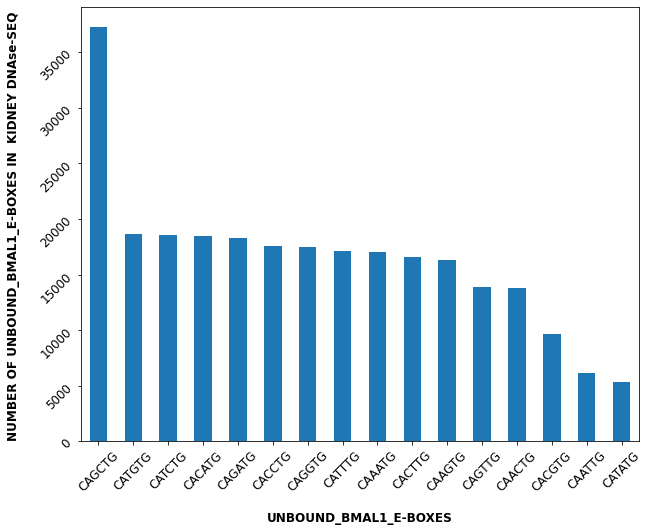

In [159]:
# Distribution of unbound CANNTG E-box motifs in heart using the hexamer
fig, ax = plt.subplots(figsize=(10, 8))
ax =Kidney_BMAL1_NOT_Bound_E_BOX.plot.bar()
ax.set_xlabel('UNBOUND_BMAL1_E-BOXES',labelpad=18,fontsize='large', fontweight='bold')
ax.set_ylabel('NUMBER OF UNBOUND_BMAL1_E-BOXES IN  KIDNEY DNAse-SEQ ',labelpad=18,fontsize='large', fontweight='bold')
plt.xticks(fontsize='large', rotation =45)
plt.yticks(fontsize='large', rotation=45)
plt.savefig('MOUSE_KIDNEY_UNBOUND_E-BOXES.png')
plt.show()

In [160]:
Kidney_BMAL1_NOT_Bound_E_BOX_seq =Kidney_BMAL1__NOT_Bound['seq'].str[FLANK_WIDTH+11:FLANK_WIDTH+15] + Kidney_BMAL1__NOT_Bound['seq'].str[FLANK_WIDTH+15:FLANK_WIDTH+21] + Kidney_BMAL1__NOT_Bound['seq'].str[FLANK_WIDTH+21:FLANK_WIDTH+25]
Kidney_BMAL1_NOT_Bound_E_BOX_seq 

564         TCTCCAATTGTCAG
565         TGCACAGCTGTGAG
577         ACTACAGATGGGAT
578         TGCTCAGCTGAGAA
580         GTCCCAAGTGCATA
                 ...      
14660245    CACTCAGATGCTCT
14660248    TTTCCAGGTGCGCG
14660249    ATTGCAGTTGAAAT
14660250    TATGCAAATGTGTG
14660256    GGTGCACTTGCGTG
Name: seq, Length: 262053, dtype: object

In [169]:
Kidney_BMAL1_NOT_Bound_E_BOX_seq.to_csv('/mnt/home/marridan/MSU_Project/BMAL1_BINDING/Negative_Kidney_E_BOX_seq.txt', sep='\t', header=0, index = False)

In [170]:
##One-hot encoding the unbound kidney E-box motifs and the flanking sequence

In [171]:
Neg_Kidney_E_box = pd.read_csv('Negative_Kidney_E_BOX_seq.txt', header = None)

In [172]:
Neg_Kidney=Neg_Kidney_E_box.loc[:,0].values
Neg_Kidney

array(['TCTCCAATTGTCAG', 'TGCACAGCTGTGAG', 'ACTACAGATGGGAT', ...,
       'ATTGCAGTTGAAAT', 'TATGCAAATGTGTG', 'GGTGCACTTGCGTG'], dtype=object)

In [173]:
#declaring variable to hold the encoded data
onehot_encoded = list()
# looping through each item in the list containing strings
for i in Neg_Kidney:
    integer_encoded = [char_to_int[char] for char in i]
    #print(integer_encoded)
    # one hot encode; variable to hold each character which would be encoded
    onehot_encoded2 = list()
    # integer encode input data
    for value in integer_encoded:
    	letter = [0 for _ in range(len(alphabet))]
    	letter[value] = 1
    	onehot_encoded2.extend(letter)
        #onehot_encoded.extend(letter)
        #onehot_encoded2=onehot_encoded
    onehot_encoded.append(onehot_encoded2)

In [174]:
Neg_Kidney_One_hot=np.asarray( onehot_encoded)
Neg_Kidney_One_hot

array([[0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 1, 0],
       [1, 0, 0, ..., 0, 0, 1],
       ...,
       [1, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 1, ..., 0, 1, 0]])

In [175]:
Neg_Kidney_One_hot.shape

(262053, 56)

In [176]:
#Saving the dataset
np.savetxt("Negative_Kidney_One_hot.csv", Neg_Kidney_One_hot, delimiter=",")

### VENN DIAGRAM OF HEART AND KIDNEY

In [177]:
from collections import Counter
from matplotlib_venn import venn2, venn3
from IPython.core.display import HTML
def multi_table(table_list): #for visualizing tables in the same cell
  return HTML(
      '<table><tr style="background-color:white;">' +
      ''.join(['<td>' + table._repr_html_() + '</td>' for table in table_list]) +
      '</tr></table>'
  ) #https://github.com/epmoyer/ipy_table/issues/24

In [178]:
Heart_Name = Heart_Dnase_datanew['name']
Heart_Name = Heart_Name.values.tolist() 


In [179]:
Kidney_Name = Kidney_Dnase_datanew['name']
Kidney_Name = Kidney_Name.values.tolist() 


In [180]:
Heart_DNAse_E_BOX = pd.DataFrame(Heart_Name,columns=['HEART_DNASE_EBOX'])
Kidney_DNAse_E_BOX = pd.DataFrame(Kidney_Name,columns=['KIDNEY_DNASE_EBOX'])
multi_table([Heart_DNAse_E_BOX,Kidney_DNAse_E_BOX])

,HEART_DNASE_EBOX
0,413
1,414
2,940
3,941
4,942
...,...
293923,14660248
293924,14660249
293925,14660250
293926,14660255


In [181]:
A = set(Heart_DNAse_E_BOX.HEART_DNASE_EBOX)
B = set(Kidney_DNAse_E_BOX.KIDNEY_DNASE_EBOX)
#C = set(dfC.CNames)

AB_overlap = A & B
#AC_overlap = A & C
#BC_overlap = B & C
#ABC_overlap = A & B & C

A_rest = A - AB_overlap 
B_rest = B - AB_overlap 
#C_rest = C - AC_overlap - BC_overlap

#AB_only = AB_overlap - ABC_overlap
#AC_only = AC_overlap - ABC_overlap
#BC_only = BC_overlap - ABC_overlap

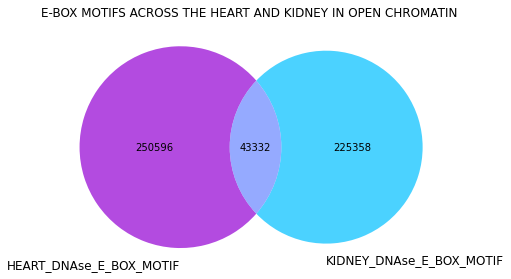

In [183]:
#overlap of open chromatin E-box motifs in the heart and kidney
sets = Counter()               #set order A, B  
sets['10'] = len(A-AB_overlap) #10 denotes A on, B off
sets['01'] = len(B-AB_overlap) #01 denotes A off, B on
sets['11'] = len(AB_overlap)   #11 denotes A on, B on
labels = ('HEART_DNAse_E_BOX_MOTIF', 'KIDNEY_DNAse_E_BOX_MOTIF')

plt.figure(figsize=(7,7))
ax = plt.gca()
v= venn2(subsets=sets, set_labels=labels, ax=ax,set_colors=('darkviolet','deepskyblue'),alpha=0.7)
plt.title('E-BOX MOTIFS ACROSS THE HEART AND KIDNEY IN OPEN CHROMATIN ')
plt.show()

### BOUND IN HEART AND KIDNEY

In [184]:
Heart_Bound = Bound_Heart_Bmal['name']
Heart_Bound = Heart_Bound.values.tolist() 


In [185]:
Kidney_Bound = Kidney_Bound_Bmal['name']
Kidney_Bound = Kidney_Bound.values.tolist() 


In [186]:
Heart_Bound_E_BOX = pd.DataFrame(Heart_Bound,columns=['HEART_BOUND_EBOX'])
Kidney_Bound_E_BOX = pd.DataFrame(Kidney_Bound,columns=['KIDNEY_BOUND_EBOX'])
multi_table([Heart_Bound_E_BOX,Kidney_Bound_E_BOX])

,HEART_BOUND_EBOX
0,179674
1,189309
2,265983
3,265984
4,266059
...,...
1308,13716911
1309,13869125
1310,14054948
1311,14054991


In [187]:
A = set(Heart_Bound_E_BOX.HEART_BOUND_EBOX)
B = set(Kidney_Bound_E_BOX.KIDNEY_BOUND_EBOX)
#C = set(dfC.CNames)

AB_overlap = A & B
#AC_overlap = A & C
#BC_overlap = B & C
#ABC_overlap = A & B & C

A_rest = A - AB_overlap 
B_rest = B - AB_overlap 
#C_rest = C - AC_overlap - BC_overlap

#AB_only = AB_overlap - ABC_overlap
#AC_only = AC_overlap - ABC_overlap
#BC_only = BC_overlap - ABC_overlap

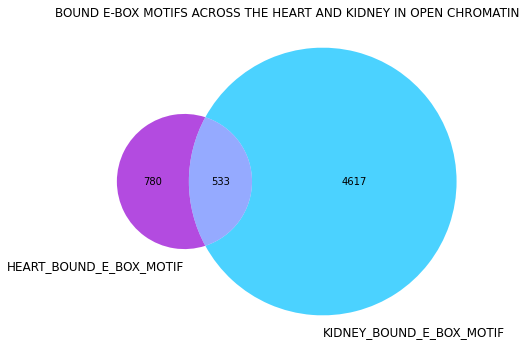

In [189]:
#overlap of bound E-box motifs in the heart and kidney
sets = Counter()               #set order A, B  
sets['10'] = len(A-AB_overlap) #10 denotes A on, B off
sets['01'] = len(B-AB_overlap) #01 denotes A off, B on
sets['11'] = len(AB_overlap)   #11 denotes A on, B on
labels = ('HEART_BOUND_E_BOX_MOTIF', 'KIDNEY_BOUND_E_BOX_MOTIF')

plt.figure(figsize=(7,7))
ax = plt.gca()
v= venn2(subsets=sets, set_labels=labels, ax=ax,set_colors=('darkviolet','deepskyblue'),alpha=0.7)
plt.title('BOUND E-BOX MOTIFS ACROSS THE HEART AND KIDNEY IN OPEN CHROMATIN')
plt.show()

### UNBOUND IN HEART AND KIDNEY

In [190]:
Heart_unBound = Un_Bound_Heart_Bmal['name']
Heart_unBound = Heart_unBound.values.tolist() 


In [191]:
Kidney_unBound = Un_bound_kidney['name']
Kidney_unBound = Kidney_unBound.values.tolist() 


In [192]:
Heart_UNBound_E_BOX = pd.DataFrame(Heart_unBound,columns=['HEART_UNBOUND_EBOX'])
Kidney_UNBound_E_BOX = pd.DataFrame(Kidney_unBound,columns=['KIDNEY_UNBOUND_EBOX'])
multi_table([Heart_UNBound_E_BOX,Kidney_UNBound_E_BOX])

,HEART_UNBOUND_EBOX
0,413
1,414
2,940
3,941
4,942
...,...
291835,14660248
291836,14660249
291837,14660250
291838,14660255


In [193]:
A = set(Heart_UNBound_E_BOX.HEART_UNBOUND_EBOX)
B = set(Kidney_UNBound_E_BOX.KIDNEY_UNBOUND_EBOX)
#C = set(dfC.CNames)

AB_overlap = A & B
#AC_overlap = A & C
#BC_overlap = B & C
#ABC_overlap = A & B & C

A_rest = A - AB_overlap 
B_rest = B - AB_overlap 
#C_rest = C - AC_overlap - BC_overlap

#AB_only = AB_overlap - ABC_overlap
#AC_only = AC_overlap - ABC_overlap
#BC_only = BC_overlap - ABC_overlap

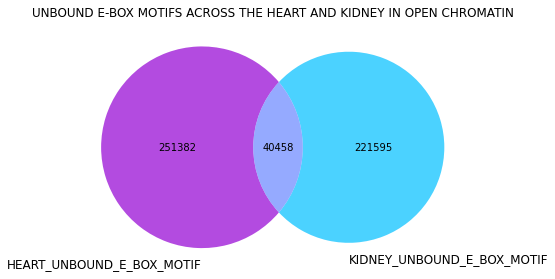

In [194]:
#overlap of open chromatin E-box motifs in the heart and kidney
sets = Counter()               #set order A, B  
sets['10'] = len(A-AB_overlap) #10 denotes A on, B off
sets['01'] = len(B-AB_overlap) #01 denotes A off, B on
sets['11'] = len(AB_overlap)   #11 denotes A on, B on
labels = ('HEART_UNBOUND_E_BOX_MOTIF', 'KIDNEY_UNBOUND_E_BOX_MOTIF')

plt.figure(figsize=(7,7))
ax = plt.gca()
v= venn2(subsets=sets, set_labels=labels, ax=ax,set_colors=('darkviolet','deepskyblue'),alpha=0.7)
plt.title('UNBOUND E-BOX MOTIFS ACROSS THE HEART AND KIDNEY IN OPEN CHROMATIN')
plt.show()

### 2.3 LIVER DATA

In [197]:
#Importing the all genome and the DNase dataset dataset

#DNase =  pybedtools.BedTool('ENCSR216UMD_rep1_1_pe_bwa_biorep_filtered_hotspots.bed')
#Bmal1 = pybedtools.BedTool('GSM3003969_Liver_BMAL1_ChIP_All_Replicates.bed')
Yes_EBox = pybedtools.BedTool('Yes_E_BOX.bed')  # All Liver E-box motifs in open chromatin
Bmal_bound = pybedtools.BedTool('DNase_Bmal1_intersect.bed')#Heart E-box motifs in open chromatin that intersect/overlap with the BMAL1 ChIP-seq bed file.
Bmal_not_bound =  pybedtools.BedTool('DNase_Bmal1_non_intersect.bed')#Heart E-box motifs in open chromatin that donot intersect/overlap with the BMAL1 ChIP-seq bed file.

### LIVER DNASE EBOX

In [198]:
#Overlaping the heart open chromatin E-box motifs with the genome E-box motif
Liver_DNase = Yes_EBox.intersect(genome, c=True).to_dataframe()
Liver_DNase

,chrom,start,end,name
0,chr1,3416184,3416400,1
1,chr1,3514804,3515299,3
2,chr1,4332527,4332764,6
3,chr1,4409157,4409416,2
4,chr1,4496387,4496655,1
...,...,...,...,...
90349,chrY,39292999,39293112,1
90350,chrY,90726244,90726330,1
90351,chrY,90739013,90740631,3
90352,chrY,90741547,90741941,2


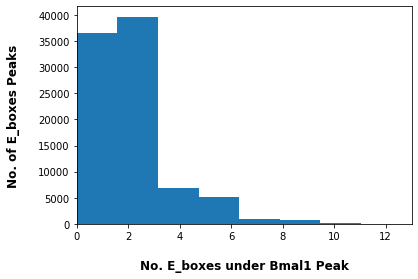

In [199]:
Count=Liver_DNase['name']
plt.hist(Count, bins= 26)
plt.xlim([0, 13])
plt.xlabel('No. E_boxes under Bmal1 Peak',labelpad=18,fontsize='large', fontweight='bold')
plt.ylabel('No. of E_boxes Peaks',labelpad=18,fontsize='large', fontweight='bold')
#plt.savefig('Bmal_peak.png')
plt.show()

In [200]:
#Extract all liver E-box motifs in open chromatin
Liver_Dnase_datanew=genome.intersect(Yes_EBox, u=True).to_dataframe()
Liver_Dnase_datanew

,chrom,start,end,name,score,strand
0,chr1,3416334,3416340,2207,1000,+
1,chr1,3514827,3514833,2724,1000,+
2,chr1,3514907,3514913,2725,1000,+
3,chr1,3515146,3515152,2726,1000,+
4,chr1,4332527,4332533,6949,1000,+
...,...,...,...,...,...,...
201713,chrY,90739245,90739251,14660249,1000,+
201714,chrY,90739262,90739268,14660250,1000,+
201715,chrY,90741560,90741566,14660254,1000,+
201716,chrY,90741826,90741832,14660255,1000,+


In [201]:
Liver_Dnase_seq = sequences.loc[Liver_Dnase_datanew['name']]


In [202]:
Liver_Dnase_seq['seq'].str[FLANK_WIDTH+15:FLANK_WIDTH+21].value_counts()

CAGCTG    28229
CACCTG    15419
CAGGTG    15395
CAGATG    15072
CATCTG    14899
CACATG    13410
CATGTG    13341
CACTTG    11607
CAAATG    11526
CAAGTG    11342
CATTTG    11224
CAGTTG    10756
CAACTG    10681
CACGTG     8824
CATATG     5228
CAATTG     4765
Name: seq, dtype: int64

In [203]:
Liver_DNAse_Count = Liver_Dnase_seq['seq'].str[FLANK_WIDTH+15:FLANK_WIDTH+21].value_counts()

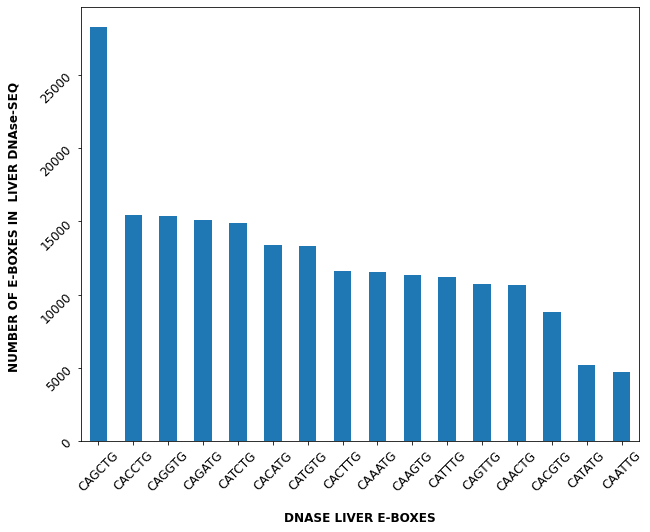

In [204]:
# Distribution of liver E-Box motifs in open chromatin using all the  hexamer CANNTG
fig, ax = plt.subplots(figsize=(10, 8))
ax = Liver_DNAse_Count.plot.bar()
ax.set_xlabel('DNASE LIVER E-BOXES',labelpad=18,fontsize='large', fontweight='bold')
ax.set_ylabel('NUMBER OF E-BOXES IN  LIVER DNAse-SEQ ',labelpad=18,fontsize='large', fontweight='bold')
plt.xticks(fontsize='large', rotation =45)
plt.yticks(fontsize='large', rotation=45)
plt.savefig('MOUSE_LIVER_TISSUE_E-BOXES.png')
plt.show()

In [205]:
#extracting the central (NN) dimer in the E-box hexamer CANNTG 
Liver_Dnase_seq['seq'].str[FLANK_WIDTH+17:FLANK_WIDTH+19].value_counts()

GC    28229
CC    15419
GG    15395
GA    15072
TC    14899
CA    13410
TG    13341
CT    11607
AA    11526
AG    11342
TT    11224
GT    10756
AC    10681
CG     8824
TA     5228
AT     4765
Name: seq, dtype: int64

In [206]:
NEW_Liver_DNAse_Count = Liver_Dnase_seq['seq'].str[FLANK_WIDTH+17:FLANK_WIDTH+19].value_counts()

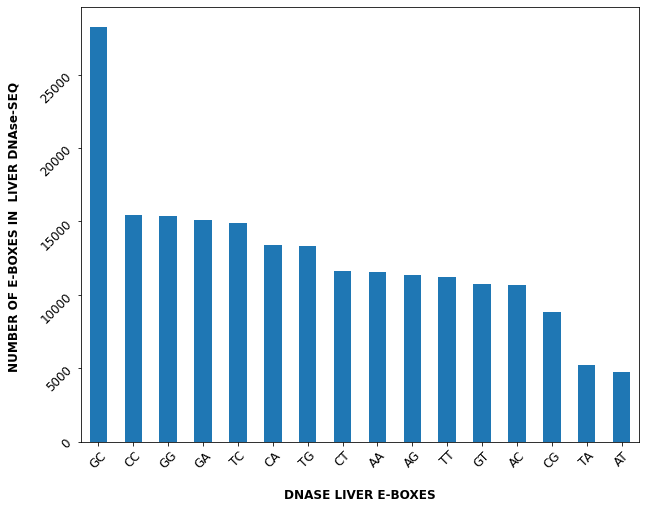

In [208]:
# Distribution of liver E-Box motifs in open chromatin using central (NN) dimer in the E-box hexamer CANNTG.
fig, ax = plt.subplots(figsize=(10, 8))
ax = NEW_Liver_DNAse_Count.plot.bar()
ax.set_xlabel('DNASE LIVER E-BOXES',labelpad=18,fontsize='large', fontweight='bold')
ax.set_ylabel('NUMBER OF E-BOXES IN  LIVER DNAse-SEQ ',labelpad=18,fontsize='large', fontweight='bold')
plt.xticks(fontsize='large', rotation =45)
plt.yticks(fontsize='large', rotation=45)
plt.savefig('NEW_MOUSE_LIVER_TISSUE_E-BOXES.png')
plt.show()

### LIVER BOUND

In [283]:
#Overlaping the liver BMAL1 chIP-seq bed file with the genome E-box motif bed file
Liver_Bound =Bmal_bound.intersect(genome, c=True).to_dataframe()
Liver_Bound

,chrom,start,end,name
0,chr1,3514883,3515125,1
1,chr1,4768989,4769162,2
2,chr1,4810426,4810586,3
3,chr1,5082962,5083204,4
4,chr1,7088946,7089188,1
...,...,...,...,...
3334,chrX,139808164,139808406,3
3335,chrX,140520260,140520502,2
3336,chrX,152232759,152233001,0
3337,chrX,160137475,160137636,3


In [210]:
Liver_Bound['name'].value_counts()

1    1054
2     944
3     581
0     363
4     280
5      81
6      32
7       2
8       2
Name: name, dtype: int64

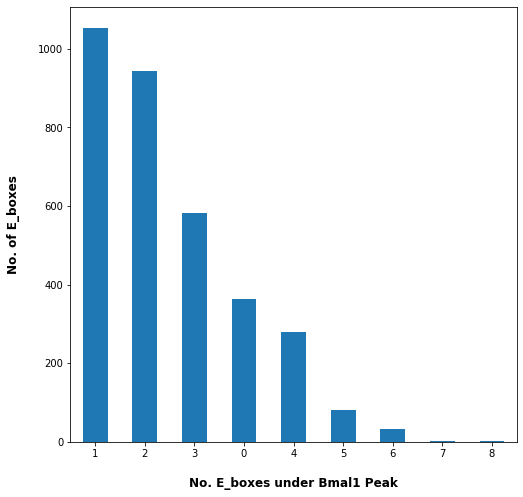

In [211]:
Liver_Bound['name'].value_counts().plot(kind='bar', figsize=(8, 8), rot=0)
plt.xlabel('No. E_boxes under Bmal1 Peak',labelpad=18, fontsize='large', fontweight='bold')
plt.ylabel('No. of E_boxes',labelpad=18,fontsize='large', fontweight='bold')
#plt.title("Count of People Who Received Tips by Gender", y=1.02);
plt.savefig('BAR_Bmal_peak.png')
plt.show()

In [214]:
Liver_Bound=pybedtools.BedTool.from_dataframe(Liver_Bound)

In [215]:
#Extracting bound E-box motifs in the liver
Liver_Bound_Bmal = genome.intersect(Bmal_bound, u=True).to_dataframe()
Liver_Bound_Bmal

,chrom,start,end,name,score,strand
0,chr1,3514907,3514913,2725,1000,+
1,chr1,4769042,4769048,9319,1000,+
2,chr1,4769053,4769059,9320,1000,+
3,chr1,4810453,4810459,9547,1000,+
4,chr1,4810513,4810519,9548,1000,+
...,...,...,...,...,...,...
6426,chrX,160137630,160137636,14158782,1000,+
6427,chrX,164382229,164382235,14182195,1000,+
6428,chrX,164382231,164382237,14182196,1000,+
6429,chrX,164382239,164382245,14182197,1000,+


In [216]:
Liver_Bound_Bmal_Seq  = sequences.loc[Liver_Bound_Bmal['name']]


In [217]:
Liver_Bound_Bmal_Seq['seq'].str[FLANK_WIDTH+15:FLANK_WIDTH+21].value_counts()

CACGTG    1631
CAGCTG     705
CATGTG     610
CACATG     583
CACCTG     525
CAGGTG     518
CAAGTG     265
CATCTG     249
CACTTG     227
CAACTG     223
CAGATG     220
CAGTTG     212
CAAATG     162
CATTTG     159
CAATTG      98
CATATG      44
Name: seq, dtype: int64

In [218]:
Liver_BMAL1_Bound_E_BOX =Liver_Bound_Bmal_Seq['seq'].str[FLANK_WIDTH+15:FLANK_WIDTH+21].value_counts()

In [219]:
Liver_BMAL1_Bound_E_BOX

CACGTG    1631
CAGCTG     705
CATGTG     610
CACATG     583
CACCTG     525
CAGGTG     518
CAAGTG     265
CATCTG     249
CACTTG     227
CAACTG     223
CAGATG     220
CAGTTG     212
CAAATG     162
CATTTG     159
CAATTG      98
CATATG      44
Name: seq, dtype: int64

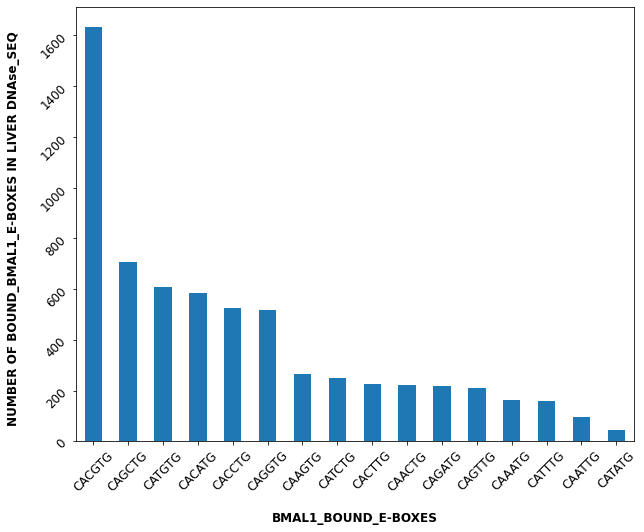

In [220]:
# Distribution of bound CANNTG E-box motifs in Kidney using hexamer CANNTG.
fig, ax = plt.subplots(figsize=(10, 8))
ax = Liver_BMAL1_Bound_E_BOX.plot.bar()
ax.set_xlabel('BMAL1_BOUND_E-BOXES',labelpad=18,fontsize='large', fontweight='bold')
ax.set_ylabel('NUMBER OF BOUND_BMAL1_E-BOXES IN LIVER DNAse_SEQ  ',labelpad=18,fontsize='large', fontweight='bold')
plt.xticks(fontsize='large', rotation =45)
plt.yticks(fontsize='large', rotation=45)
plt.savefig('MOUSE_LIVER_BOUND_E-BOXES.png')
plt.show()

In [221]:
# extract the distribution of bound CANNTG E-box motifs in heart using the central (NN) dimer
Liver_Bound_Bmal_Seq['seq'].str[FLANK_WIDTH+17:FLANK_WIDTH+19].value_counts()

CG    1631
GC     705
TG     610
CA     583
CC     525
GG     518
AG     265
TC     249
CT     227
AC     223
GA     220
GT     212
AA     162
TT     159
AT      98
TA      44
Name: seq, dtype: int64

In [222]:
NEW_Liver_BMAL1_Bound_E_BOX =Liver_Bound_Bmal_Seq['seq'].str[FLANK_WIDTH+17:FLANK_WIDTH+19].value_counts()

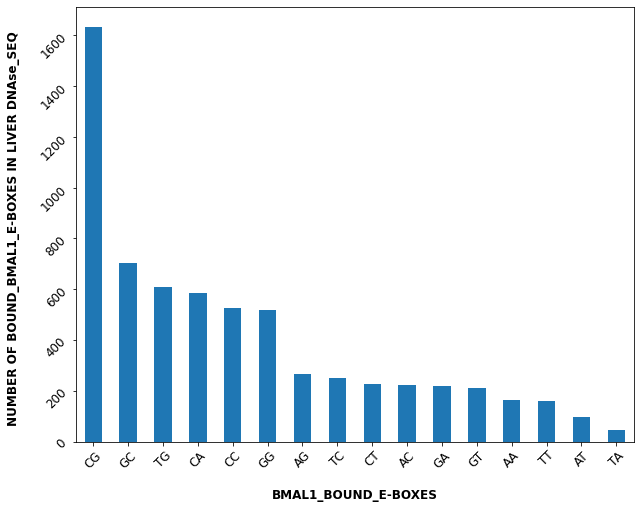

In [224]:
# Distribution of bound CANNTG E-box motifs in heart using the central (NN) dimer
fig, ax = plt.subplots(figsize=(10, 8))
ax = NEW_Liver_BMAL1_Bound_E_BOX.plot.bar()
ax.set_xlabel('BMAL1_BOUND_E-BOXES',labelpad=18,fontsize='large', fontweight='bold')
ax.set_ylabel('NUMBER OF BOUND_BMAL1_E-BOXES IN LIVER DNAse_SEQ  ',labelpad=18,fontsize='large', fontweight='bold')
plt.xticks(fontsize='large', rotation =45)
plt.yticks(fontsize='large', rotation=45)
plt.savefig('NEW_MOUSE_LIVER_BOUND_E-BOXES.png')
plt.show()

### Getting the bound motif

### Getting the singleton bound motifs

In [225]:
Liver_Bound = Liver_Bound.to_dataframe()


In [226]:
Singleton_Liver_bound = pybedtools.BedTool.from_dataframe(Liver_Bound[Liver_Bound['name']==1])
Singleton_Liver_bound.to_dataframe()

,chrom,start,end,name
0,chr1,3514883,3515125,1
1,chr1,7088946,7089188,1
2,chr1,9848199,9848441,1
3,chr1,13241411,13241653,1
4,chr1,13574913,13575123,1
...,...,...,...,...
1049,chrX,20961496,20961715,1
1050,chrX,48513392,48513634,1
1051,chrX,75155706,75155948,1
1052,chrX,77509254,77509496,1


In [227]:
Singleton_Liver_bound = genome.intersect(Singleton_Liver_bound , u=True).to_dataframe()
Singleton_Liver_bound

,chrom,start,end,name,score,strand
0,chr1,3514907,3514913,2725,1000,+
1,chr1,7088987,7088993,21763,1000,+
2,chr1,9848298,9848304,36042,1000,+
3,chr1,13241543,13241549,54623,1000,+
4,chr1,13574987,13574993,56470,1000,+
...,...,...,...,...,...,...
1049,chrX,20961634,20961640,13446871,1000,+
1050,chrX,48513573,48513579,13579937,1000,+
1051,chrX,75155797,75155803,13721539,1000,+
1052,chrX,77509398,77509404,13734275,1000,+


### Getting the non-singleton bound motifs

In [228]:
Non_Singleton_Liver_bound = pybedtools.BedTool.from_dataframe(Liver_Bound[Liver_Bound['name']>1])
Non_Singleton_Liver_bound.to_dataframe()

,chrom,start,end,name
0,chr1,4768989,4769162,2
1,chr1,4810426,4810586,3
2,chr1,5082962,5083204,4
3,chr1,7397735,7397977,2
4,chr1,9907058,9907170,2
...,...,...,...,...
1917,chrX,106186731,106186973,3
1918,chrX,139808164,139808406,3
1919,chrX,140520260,140520502,2
1920,chrX,160137475,160137636,3


In [229]:
Non_Singleton_Liver_bound = genome.intersect(Non_Singleton_Liver_bound, u=True).to_dataframe()
Non_Singleton_Liver_bound

,chrom,start,end,name,score,strand
0,chr1,4769042,4769048,9319,1000,+
1,chr1,4769053,4769059,9320,1000,+
2,chr1,4810453,4810459,9547,1000,+
3,chr1,4810513,4810519,9548,1000,+
4,chr1,4810527,4810533,9549,1000,+
...,...,...,...,...,...,...
5372,chrX,160137630,160137636,14158782,1000,+
5373,chrX,164382229,164382235,14182195,1000,+
5374,chrX,164382231,164382237,14182196,1000,+
5375,chrX,164382239,164382245,14182197,1000,+


In [230]:
Liver_New = Non_Singleton_Liver_bound[Non_Singleton_Liver_bound['name']%2!=0] 
Liver_New

,chrom,start,end,name,score,strand
0,chr1,4769042,4769048,9319,1000,+
2,chr1,4810453,4810459,9547,1000,+
4,chr1,4810527,4810533,9549,1000,+
5,chr1,5083030,5083036,11071,1000,+
7,chr1,5083088,5083094,11073,1000,+
...,...,...,...,...,...,...
5367,chrX,139808354,139808360,14051189,1000,+
5368,chrX,140520383,140520389,14054991,1000,+
5371,chrX,160137618,160137624,14158781,1000,+
5373,chrX,164382229,164382235,14182195,1000,+


In [231]:
#Combining the singleton and non singleton E-box motifs
Liver_Positive_bed = pd.concat([Singleton_Liver_bound,Liver_New],ignore_index=True)
Liver_Positive_bed

,chrom,start,end,name,score,strand
0,chr1,3514907,3514913,2725,1000,+
1,chr1,7088987,7088993,21763,1000,+
2,chr1,9848298,9848304,36042,1000,+
3,chr1,13241543,13241549,54623,1000,+
4,chr1,13574987,13574993,56470,1000,+
...,...,...,...,...,...,...
3720,chrX,139808354,139808360,14051189,1000,+
3721,chrX,140520383,140520389,14054991,1000,+
3722,chrX,160137618,160137624,14158781,1000,+
3723,chrX,164382229,164382235,14182195,1000,+


In [232]:
# Extending the motifs to include 747 nucleotide flanking sequence upstream and downstream of the motif. This was used to process the histone mofification features.
Liver_Positive_bed['start'] = Liver_Positive_bed['start'] - 747
Liver_Positive_bed['end'] = Liver_Positive_bed['end'] + 747
Liver_Positive_bed

,chrom,start,end,name,score,strand
0,chr1,3514160,3515660,2725,1000,+
1,chr1,7088240,7089740,21763,1000,+
2,chr1,9847551,9849051,36042,1000,+
3,chr1,13240796,13242296,54623,1000,+
4,chr1,13574240,13575740,56470,1000,+
...,...,...,...,...,...,...
3720,chrX,139807607,139809107,14051189,1000,+
3721,chrX,140519636,140521136,14054991,1000,+
3722,chrX,160136871,160138371,14158781,1000,+
3723,chrX,164381482,164382982,14182195,1000,+


In [233]:
#Saving the bed file
Liver_Positive_bed.to_csv('/mnt/home/marridan/MSU_Project/BMAL1_BINDING/Liver_Bound_Bmal_Positive_Extract.bed', sep='\t', header=0, index = False)

In [234]:
Liver_Positive_bed_Seq = sequences.loc[Liver_Positive_bed['name']]


In [236]:
#extract the distribution of bound CANNTG E-box motifs in heart
Liver_Positive_bed_Seq['seq'].str[FLANK_WIDTH+15:FLANK_WIDTH+21].value_counts()

CACGTG    996
CAGCTG    395
CACATG    344
CATGTG    335
CACCTG    317
CAGGTG    311
CAAGTG    162
CATCTG    142
CAACTG    132
CAGATG    132
CAGTTG    118
CACTTG    110
CAAATG     82
CATTTG     79
CAATTG     44
CATATG     26
Name: seq, dtype: int64

In [237]:
Liver_Positive_Seq = Liver_Positive_bed_Seq['seq'].str[FLANK_WIDTH+11:FLANK_WIDTH+15] + Liver_Positive_bed_Seq['seq'].str[FLANK_WIDTH+15:FLANK_WIDTH+21] + Liver_Positive_bed_Seq['seq'].str[FLANK_WIDTH+21:FLANK_WIDTH+25]
Liver_Positive_Seq 

2725        AGGTCAATTGAAAT
21763       AGTCCAGCTGCCCG
36042       GGGGCAGGTGGGTG
54623       TGCTCAACTGTAAG
56470       TGATCAACTGCAAA
                 ...      
14051189    AAAACATGTGCCTA
14054991    GGGCCACGTGAGGT
14158781    TCCACAAATGCTCA
14182195    CACCCACATGTGTC
14182197    TGTCCAGATGCCTG
Name: seq, Length: 3725, dtype: object

In [239]:
Liver_Positive_Seq.to_csv('/mnt/home/marridan/MSU_Project/BMAL1_BINDING/Liver_Bound_Bmal_Positive.txt', sep='\t', header=0, index = False)

In [240]:
##One-hot encoding the bound liver E-box motifs and the flanking sequence

In [241]:

Liver_bound_ebox = pd.read_csv('Liver_Bound_Bmal_Positive.txt', header = None)

In [242]:
Pos_Liver = Liver_bound_ebox.loc[:,0].values
Pos_Liver

array(['AGGTCAATTGAAAT', 'AGTCCAGCTGCCCG', 'GGGGCAGGTGGGTG', ...,
       'TCCACAAATGCTCA', 'CACCCACATGTGTC', 'TGTCCAGATGCCTG'], dtype=object)

In [243]:
# defining the values to be used. If not defined, normal 26 alphabet length might be used by program
alphabet = 'ACGT'

In [244]:
# defining a mapping of characters to integers
char_to_int = dict((c, i) for i, c in enumerate(alphabet))
int_to_char = dict((i, c) for i, c in enumerate(alphabet))

In [245]:
#declaring variable to hold the encoded data
onehot_encoded = list()
# looping through each item in the list containing strings
for i in Pos_Liver:
    integer_encoded = [char_to_int[char] for char in i]
    #print(integer_encoded)
    # one hot encode; variable to hold each character which would be encoded
    onehot_encoded2 = list()
    # integer encode input data
    for value in integer_encoded:
    	letter = [0 for _ in range(len(alphabet))]
    	letter[value] = 1
    	onehot_encoded2.extend(letter)
        #onehot_encoded.extend(letter)
        #onehot_encoded2=onehot_encoded
    onehot_encoded.append(onehot_encoded2)

In [246]:
Pos_Liver_One_hot=np.asarray( onehot_encoded)
Pos_Liver_One_hot

array([[1, 0, 0, ..., 0, 0, 1],
       [1, 0, 0, ..., 0, 1, 0],
       [0, 0, 1, ..., 0, 1, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 1, 0]])

In [247]:
Pos_Liver_One_hot.shape

(3725, 56)

In [248]:
#Saving the encoded data
np.savetxt("Positive_Liver_One_hot.csv", Pos_Liver_One_hot, delimiter=",")

# LIVER UNBOUND 

In [249]:
#Overlaping the heart unbound motif bed file with the genome E-box motif bed file
Liver_Bmal_not_bound = Bmal_not_bound.intersect(genome, c=True).to_dataframe()
Liver_Bmal_not_bound

,chrom,start,end,name
0,chr1,3416184,3416400,1
1,chr1,4332527,4332764,6
2,chr1,4409157,4409416,2
3,chr1,4496387,4496655,1
4,chr1,4496683,4496779,2
...,...,...,...,...
87027,chrY,39292999,39293112,1
87028,chrY,90726244,90726330,1
87029,chrY,90739013,90740631,3
87030,chrY,90741547,90741941,2


In [250]:
Liver_Bmal_unbound =pybedtools.BedTool.from_dataframe(Liver_Bmal_not_bound)
 

In [251]:
Un_bound_Liver = genome.intersect(Liver_Bmal_unbound, u=True).to_dataframe()
Un_bound_Liver

,chrom,start,end,name,score,strand
0,chr1,3416334,3416340,2207,1000,+
1,chr1,4332527,4332533,6949,1000,+
2,chr1,4332591,4332597,6950,1000,+
3,chr1,4332667,4332673,6951,1000,+
4,chr1,4332685,4332691,6952,1000,+
...,...,...,...,...,...,...
189576,chrY,90739245,90739251,14660249,1000,+
189577,chrY,90739262,90739268,14660250,1000,+
189578,chrY,90741560,90741566,14660254,1000,+
189579,chrY,90741826,90741832,14660255,1000,+


In [252]:
# Extending the motifs to include 743 nucleotide flanking sequence upstream and downstream of the motif. This was used to process the histone mofification features.
Un_bound_Liver['start'] = Un_bound_Liver['start'] - 747
Un_bound_Liver['end'] = Un_bound_Liver['end'] + 747
Un_bound_Liver

,chrom,start,end,name,score,strand
0,chr1,3415587,3417087,2207,1000,+
1,chr1,4331780,4333280,6949,1000,+
2,chr1,4331844,4333344,6950,1000,+
3,chr1,4331920,4333420,6951,1000,+
4,chr1,4331938,4333438,6952,1000,+
...,...,...,...,...,...,...
189576,chrY,90738498,90739998,14660249,1000,+
189577,chrY,90738515,90740015,14660250,1000,+
189578,chrY,90740813,90742313,14660254,1000,+
189579,chrY,90741079,90742579,14660255,1000,+


In [253]:
Un_bound_Liver.to_csv('/mnt/home/marridan/MSU_Project/BMAL1_BINDING/Liver_UnBound_Bmal_Negative_Extract.bed', sep='\t', header=0, index = False)

In [254]:
Liver_BMAL1__NOT_Bound  = sequences.loc[Un_bound_Liver['name']]

In [258]:
#extract the distribution of unbound CANNTG E-box motifs in liver
Liver_BMAL1__NOT_Bound['seq'].str[FLANK_WIDTH+15:FLANK_WIDTH+21].value_counts()

CAGCTG    26716
CAGATG    14463
CACCTG    14354
CAGGTG    14345
CATCTG    14251
CACATG    12521
CATGTG    12461
CAAATG    11045
CACTTG    11042
CATTTG    10765
CAAGTG    10716
CAGTTG    10227
CAACTG    10159
CACGTG     6888
CATATG     5080
CAATTG     4548
Name: seq, dtype: int64

In [259]:
Liver_BMAL1_NOT_Bound_E_BOX = Liver_BMAL1__NOT_Bound['seq'].str[FLANK_WIDTH+15:FLANK_WIDTH+21].value_counts()

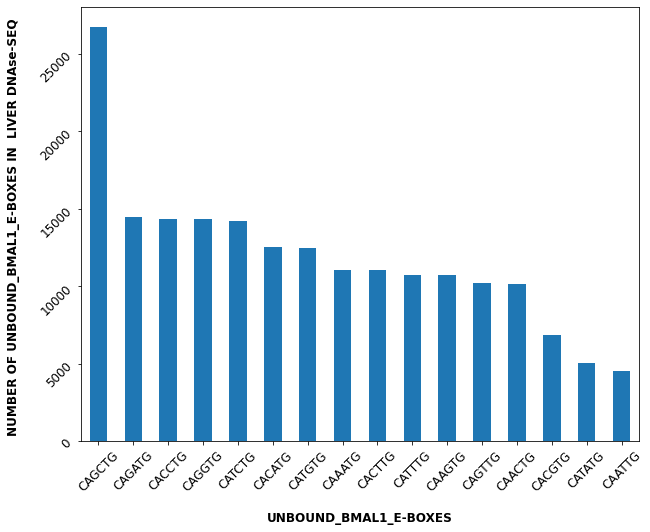

In [260]:
# Distribution of unbound CANNTG E-box motifs in liver using the hexamer
fig, ax = plt.subplots(figsize=(10, 8))
ax = Liver_BMAL1_NOT_Bound_E_BOX.plot.bar()
ax.set_xlabel('UNBOUND_BMAL1_E-BOXES',labelpad=18,fontsize='large', fontweight='bold')
ax.set_ylabel('NUMBER OF UNBOUND_BMAL1_E-BOXES IN  LIVER DNAse-SEQ ',labelpad=18,fontsize='large', fontweight='bold')
plt.xticks(fontsize='large', rotation =45)
plt.yticks(fontsize='large', rotation=45)
plt.savefig('MOUSE_LIVER_UNBOUND_E-BOXES.png')
plt.show()

In [261]:
Liver_BMAL1_NOT_Bound_E_BOX_seq = Liver_BMAL1__NOT_Bound['seq'].str[FLANK_WIDTH+11:FLANK_WIDTH+15] + Liver_BMAL1__NOT_Bound['seq'].str[FLANK_WIDTH+15:FLANK_WIDTH+21] + Liver_BMAL1__NOT_Bound['seq'].str[FLANK_WIDTH+21:FLANK_WIDTH+25]
Liver_BMAL1_NOT_Bound_E_BOX_seq 

2207        GTCCCAGCTGAGTA
6949        CCTACAGTTGTTTT
6950        GCTGCACCTGAAAG
6951        TTCACAACTGCCAT
6952        TGTTCAAATGTATA
                 ...      
14660249    ATTGCAGTTGAAAT
14660250    TATGCAAATGTGTG
14660254    TGCACAGGTGTTGG
14660255    TGCACAGGTGGTGG
14660256    GGTGCACTTGCGTG
Name: seq, Length: 189581, dtype: object

In [262]:
Liver_BMAL1_NOT_Bound_E_BOX_seq.to_csv('/mnt/home/marridan/MSU_Project/BMAL1_BINDING/Negative_Liver_E_BOX_seq.txt', sep='\t', header=0, index = False)

In [263]:
##One-hot encoding the unbound liver E-box motifs and the flanking sequence

In [264]:
Neg_Liver_E_box = pd.read_csv('Negative_Liver_E_BOX_seq.txt', header = None)

In [265]:
Neg_Liver=Neg_Liver_E_box.loc[:,0].values
Neg_Liver

array(['GTCCCAGCTGAGTA', 'CCTACAGTTGTTTT', 'GCTGCACCTGAAAG', ...,
       'TGCACAGGTGTTGG', 'TGCACAGGTGGTGG', 'GGTGCACTTGCGTG'], dtype=object)

In [266]:
#declaring variable to hold the encoded data
onehot_encoded = list()
# looping through each item in the list containing strings
for i in Neg_Liver:
    integer_encoded = [char_to_int[char] for char in i]
    #print(integer_encoded)
    # one hot encode; variable to hold each character which would be encoded
    onehot_encoded2 = list()
    # integer encode input data
    for value in integer_encoded:
    	letter = [0 for _ in range(len(alphabet))]
    	letter[value] = 1
    	onehot_encoded2.extend(letter)
        #onehot_encoded.extend(letter)
        #onehot_encoded2=onehot_encoded
    onehot_encoded.append(onehot_encoded2)

In [267]:
Neg_Liver_One_hot=np.asarray( onehot_encoded)
Neg_Liver_One_hot

array([[0, 0, 1, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 1],
       [0, 0, 1, ..., 0, 1, 0],
       ...,
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 1, ..., 0, 1, 0]])

In [268]:
Neg_Liver_One_hot.shape

(189581, 56)

In [269]:
np.savetxt("Negative_Liver_One_hot.csv", Neg_Liver_One_hot, delimiter=",")

### PLOTS FOR E-BOX PEAKS IN ChIP_SEQ

In [281]:
Kidney_Bound

,chrom,start,end,name,score,strand,thickStart
0,chr11,98783397,98783585,chr11.1,304,+,5
1,chr14,18238497,18238540,chr14.1,301,+,1
2,chr7,45707664,45707852,chr7.1,285,+,2
3,chr11,98773820,98773966,chr11.2,290,+,3
4,chr15,81810883,81811071,chr15.1,277,+,3
...,...,...,...,...,...,...,...
3074,chr17,28682741,28682929,chr17.439,14,+,2
3075,chr18,39467051,39467239,chr18.226,14,+,1
3076,chr18,80151061,80151180,chr18.249,14,+,1
3077,chr19,11770352,11770460,chr19.329,14,+,0


In [282]:
Kidney_Bound_rename = Kidney_Bound.rename(columns= {'thickStart':'KIDNEY_thickStart'})
Kidney_Bound_rename

,chrom,start,end,name,score,strand,KIDNEY_thickStart
0,chr11,98783397,98783585,chr11.1,304,+,5
1,chr14,18238497,18238540,chr14.1,301,+,1
2,chr7,45707664,45707852,chr7.1,285,+,2
3,chr11,98773820,98773966,chr11.2,290,+,3
4,chr15,81810883,81811071,chr15.1,277,+,3
...,...,...,...,...,...,...,...
3074,chr17,28682741,28682929,chr17.439,14,+,2
3075,chr18,39467051,39467239,chr18.226,14,+,1
3076,chr18,80151061,80151180,chr18.249,14,+,1
3077,chr19,11770352,11770460,chr19.329,14,+,0


In [284]:
Liver_Bound

,chrom,start,end,name
0,chr1,3514883,3515125,1
1,chr1,4768989,4769162,2
2,chr1,4810426,4810586,3
3,chr1,5082962,5083204,4
4,chr1,7088946,7089188,1
...,...,...,...,...
3334,chrX,139808164,139808406,3
3335,chrX,140520260,140520502,2
3336,chrX,152232759,152233001,0
3337,chrX,160137475,160137636,3


In [285]:
Liver_Bound_rename = Liver_Bound.rename(columns= {'name':'LIVER_thickStart'})
Liver_Bound_rename

,chrom,start,end,LIVER_thickStart
0,chr1,3514883,3515125,1
1,chr1,4768989,4769162,2
2,chr1,4810426,4810586,3
3,chr1,5082962,5083204,4
4,chr1,7088946,7089188,1
...,...,...,...,...
3334,chrX,139808164,139808406,3
3335,chrX,140520260,140520502,2
3336,chrX,152232759,152233001,0
3337,chrX,160137475,160137636,3


In [287]:
Heart_Bmal

,chrom,start,end,name,score,strand,thickStart
0,chr11,98783395,98783593,chr11.1,375,+,5
1,chr14,18238491,18238580,chr14.1,324,+,2
2,chr7,45707660,45707847,chr7.1,308,+,3
3,chr11,98773860,98773989,chr11.2,305,+,2
4,chr15,81810863,81810980,chr15.1,297,+,1
...,...,...,...,...,...,...,...
1045,chr4,12241009,12241178,chr4.1446,16,+,1
1046,chr8,121736460,121736540,chr8.1783,16,+,0
1047,chr10,58989780,58989911,chr10.1202,16,+,2
1048,chr11,21647680,21647782,chr11.1907,16,+,1


In [288]:
Heart_Bound_rename = Heart_Bmal.rename(columns= {'thickStart':'HEART_thickStart'})
Heart_Bound_rename

,chrom,start,end,name,score,strand,HEART_thickStart
0,chr11,98783395,98783593,chr11.1,375,+,5
1,chr14,18238491,18238580,chr14.1,324,+,2
2,chr7,45707660,45707847,chr7.1,308,+,3
3,chr11,98773860,98773989,chr11.2,305,+,2
4,chr15,81810863,81810980,chr15.1,297,+,1
...,...,...,...,...,...,...,...
1045,chr4,12241009,12241178,chr4.1446,16,+,1
1046,chr8,121736460,121736540,chr8.1783,16,+,0
1047,chr10,58989780,58989911,chr10.1202,16,+,2
1048,chr11,21647680,21647782,chr11.1907,16,+,1


In [289]:
Liver = pd.DataFrame(Liver_Bound_rename['LIVER_thickStart'].value_counts())
Liver

,LIVER_thickStart
1,1054
2,944
3,581
0,363
4,280
5,81
6,32
7,2
8,2


In [290]:
Kidney= pd.DataFrame(Kidney_Bound_rename['KIDNEY_thickStart'].value_counts())
Kidney

,KIDNEY_thickStart
1,1299
2,866
3,414
0,294
4,159
5,36
7,6
6,4
8,1


In [291]:
Heart = pd.DataFrame(Heart_Bound_rename['HEART_thickStart'].value_counts())
Heart

,HEART_thickStart
1,446
0,245
2,231
3,91
4,26
5,9
6,2


In [292]:
Liver_Kidney = pd.merge(Liver,Kidney, left_index=True, right_index=True)

In [293]:
pd.merge(Liver_Kidney,Heart, left_index=True, right_index=True)

,LIVER_thickStart,KIDNEY_thickStart,HEART_thickStart
1,1054,1299,446
2,944,866,231
3,581,414,91
0,363,294,245
4,280,159,26
5,81,36,9
6,32,4,2


In [294]:
All_Three= pd.DataFrame(data = {'ind': [0,1,'2+'],'Liver': [363, 1054, 1922], 'Kidney': [294, 1299, 1486], 'Heart': [245, 446, 359] })
All_Three


,ind,Liver,Kidney,Heart
0,0,363,294,245
1,1,1054,1299,446
2,2+,1922,1486,359


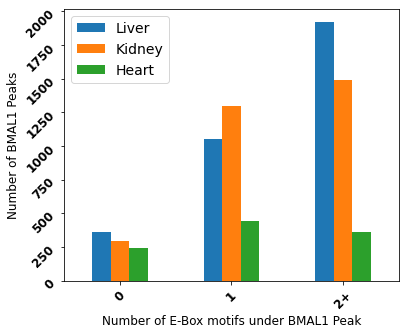

In [295]:
#Distribution of BMAL1 peaks with zero (0-E-Box), exactly one (singleton E-box) and multi (two or more E-box) E-box motifs in the liver (blue), kidney (orange) and heart (green).
All_Three.plot(x='ind', y=["Liver", "Kidney", "Heart"], kind="bar",figsize=(6,5))
#fig.set_size_inches(6, 6)
plt.xlabel("Number of E-Box motifs under BMAL1 Peak",fontsize=12)
plt.ylabel("Number of BMAL1 Peaks",fontsize=12)
plt.xticks(fontsize=12, rotation =45,fontweight ="bold")
plt.yticks(fontsize=12,rotation=45,fontweight ="bold")
plt.legend(fontsize=14)
plt.savefig('E_BOX_MOTIFS_DISTRIBUTION.png')
plt.show()

### VENN DIAGRAM OF LIVER,  HEART AND KIDNEY

In [296]:
Liver_Name = Liver_Dnase_datanew['name']
Liver_Name = Liver_Name.values.tolist() 

In [297]:
Heart_Name = Heart_Dnase_datanew['name']
Heart_Name = Heart_Name.values.tolist() 


In [298]:
Kidney_Name = Kidney_Dnase_datanew['name']
Kidney_Name = Kidney_Name.values.tolist() 


In [299]:
Liver_DNAse_E_BOX = pd.DataFrame(Liver_Name,columns=['LIVER_DNASE_EBOX'])
Heart_DNAse_E_BOX = pd.DataFrame(Heart_Name,columns=['HEART_DNASE_EBOX'])
Kidney_DNAse_E_BOX = pd.DataFrame(Kidney_Name,columns=['KIDNEY_DNASE_EBOX'])
multi_table([Liver_DNAse_E_BOX,Kidney_DNAse_E_BOX])

,LIVER_DNASE_EBOX
0,2207
1,2724
2,2725
3,2726
4,6949
...,...
201713,14660249
201714,14660250
201715,14660254
201716,14660255


In [300]:
A = set(Liver_DNAse_E_BOX.LIVER_DNASE_EBOX)
B = set(Kidney_DNAse_E_BOX.KIDNEY_DNASE_EBOX)
#C = set(dfC.CNames)

AB_overlap = A & B
#AC_overlap = A & C
#BC_overlap = B & C
#ABC_overlap = A & B & C

A_rest = A - AB_overlap 
B_rest = B - AB_overlap 
#C_rest = C - AC_overlap - BC_overlap

#AB_only = AB_overlap - ABC_overlap
#AC_only = AC_overlap - ABC_overlap
#BC_only = BC_overlap - ABC_overlap

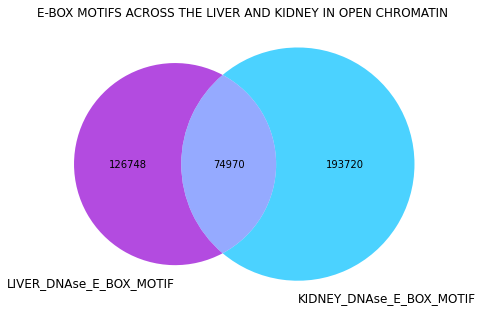

In [301]:
#overlap of open chromatin E-box motifs in the liver and kidney 
sets = Counter()               #set order A, B  
sets['10'] = len(A-AB_overlap) #10 denotes A on, B off
sets['01'] = len(B-AB_overlap) #01 denotes A off, B on
sets['11'] = len(AB_overlap)   #11 denotes A on, B on
labels = ('LIVER_DNAse_E_BOX_MOTIF', 'KIDNEY_DNAse_E_BOX_MOTIF')

plt.figure(figsize=(7,7))
ax = plt.gca()
v= venn2(subsets=sets, set_labels=labels, ax=ax,set_colors=('darkviolet','deepskyblue'),alpha=0.7)
plt.title('E-BOX MOTIFS ACROSS THE LIVER AND KIDNEY IN OPEN CHROMATIN ')
plt.show()

In [302]:
multi_table([Liver_DNAse_E_BOX,Heart_DNAse_E_BOX])

,LIVER_DNASE_EBOX
0,2207
1,2724
2,2725
3,2726
4,6949
...,...
201713,14660249
201714,14660250
201715,14660254
201716,14660255


In [303]:
A = set(Liver_DNAse_E_BOX.LIVER_DNASE_EBOX)
B = set(Heart_DNAse_E_BOX.HEART_DNASE_EBOX)
#C = set(dfC.CNames)

AB_overlap = A & B
#AC_overlap = A & C
#BC_overlap = B & C
#ABC_overlap = A & B & C

A_rest = A - AB_overlap 
B_rest = B - AB_overlap 
#C_rest = C - AC_overlap - BC_overlap

#AB_only = AB_overlap - ABC_overlap
#AC_only = AC_overlap - ABC_overlap
#BC_only = BC_overlap - ABC_overlap

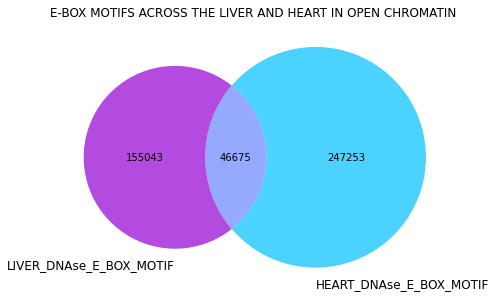

In [304]:
#overlap of  open chromatin E-box motifs in the liver and heart 
sets = Counter()               #set order A, B  
sets['10'] = len(A-AB_overlap) #10 denotes A on, B off
sets['01'] = len(B-AB_overlap) #01 denotes A off, B on
sets['11'] = len(AB_overlap)   #11 denotes A on, B on
labels = ('LIVER_DNAse_E_BOX_MOTIF', 'HEART_DNAse_E_BOX_MOTIF')

plt.figure(figsize=(7,7))
ax = plt.gca()
v= venn2(subsets=sets, set_labels=labels, ax=ax,set_colors=('darkviolet','deepskyblue'),alpha=0.7)
plt.title('E-BOX MOTIFS ACROSS THE LIVER AND HEART IN OPEN CHROMATIN ')
plt.show()

### ALL DNASE

In [305]:
multi_table([Liver_DNAse_E_BOX,Heart_DNAse_E_BOX,Kidney_DNAse_E_BOX ])

,LIVER_DNASE_EBOX
0,2207
1,2724
2,2725
3,2726
4,6949
...,...
201713,14660249
201714,14660250
201715,14660254
201716,14660255


In [306]:
A = set(Liver_DNAse_E_BOX.LIVER_DNASE_EBOX)
B = set(Heart_DNAse_E_BOX.HEART_DNASE_EBOX)
C = set(Kidney_DNAse_E_BOX.KIDNEY_DNASE_EBOX)

AB_overlap = A & B
AC_overlap = A & C
BC_overlap = B & C
ABC_overlap = A & B & C

A_rest = A - AB_overlap 
B_rest = B - AB_overlap 
C_rest = C - AC_overlap - BC_overlap

AB_only = AB_overlap - ABC_overlap
AC_only = AC_overlap - ABC_overlap
BC_only = BC_overlap - ABC_overlap

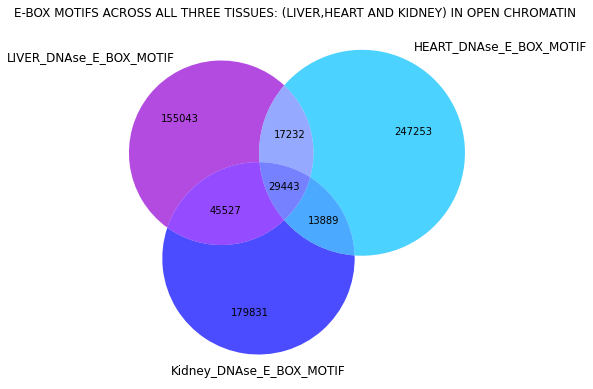

In [307]:
#overlap of  open chromatin E-box motifs in the liver, heart and kidney. 
sets = Counter()               #set order A, B, C  
sets['100'] = len(A_rest)      #100 denotes A on, B off, C off
sets['001'] = len(C_rest)      #001 denotes A off, B off, C on
sets['010'] = len(B_rest)      #010 denotes A off, B on, C off
sets['101'] = len(AC_only)     #101 denotes A on, B off, C on
sets['110'] = len(AB_only)     #110 denotes A on, B on, C off
sets['011'] = len(BC_only)     #011 denotes A off, B on, C on
sets['111'] = len(ABC_overlap) #011 denotes A on, B on, C on
labels = ('LIVER_DNAse_E_BOX_MOTIF', 'HEART_DNAse_E_BOX_MOTIF', 'Kidney_DNAse_E_BOX_MOTIF')

plt.figure(figsize=(7,7))
ax = plt.gca()
venn3(subsets=sets, set_labels=labels, ax=ax,set_colors=('darkviolet','deepskyblue','blue'),alpha=0.7)   
plt.title('E-BOX MOTIFS ACROSS ALL THREE TISSUES: (LIVER,HEART AND KIDNEY) IN OPEN CHROMATIN ')
plt.savefig('E-BOX MOTIFS ACROSS ALL THREE TISSUES.png')
plt.show()

### BOUND E-BOX 

In [308]:
Liver_Bound = Liver_Bound_Bmal['name']
Liver_Bound = Liver_Bound.values.tolist() 


In [309]:
Heart_Bound = Bound_Heart_Bmal['name']
Heart_Bound  = Heart_Bound.values.tolist() 
 

In [310]:
Kidney_Bound  = Kidney_Bound_Bmal['name']
Kidney_Bound  = Kidney_Bound.values.tolist() 
 

In [311]:
Liver_Bound_E_BOX = pd.DataFrame(Liver_Bound,columns=['LIVER_BOUND_EBOX'])
Heart_Bound_E_BOX = pd.DataFrame(Heart_Bound,columns=['HEART_BOUND_EBOX'])
Kidney_Bound_E_BOX = pd.DataFrame(Kidney_Bound,columns=['KIDNEY_BOUND_EBOX'])
multi_table([Liver_Bound_E_BOX,Kidney_Bound_E_BOX])

,LIVER_BOUND_EBOX
0,2725
1,9319
2,9320
3,9547
4,9548
...,...
6426,14158782
6427,14182195
6428,14182196
6429,14182197


In [312]:
A = set(Liver_Bound_E_BOX.LIVER_BOUND_EBOX)
B = set(Kidney_Bound_E_BOX.KIDNEY_BOUND_EBOX)
#C = set(dfC.CNames)

AB_overlap = A & B
#AC_overlap = A & C
#BC_overlap = B & C
#ABC_overlap = A & B & C

A_rest = A - AB_overlap 
B_rest = B - AB_overlap 
#C_rest = C - AC_overlap - BC_overlap

#AB_only = AB_overlap - ABC_overlap
#AC_only = AC_overlap - ABC_overlap
#BC_only = BC_overlap - ABC_overlap

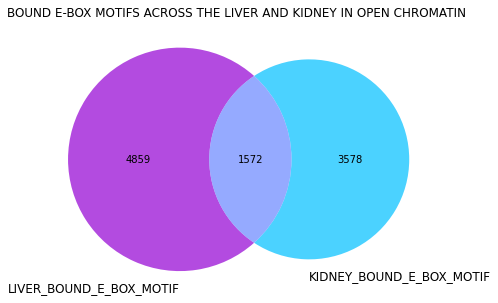

In [313]:
#overlap of bound open chromatin E-box motifs in the liver and kidney 
sets = Counter()               #set order A, B  
sets['10'] = len(A-AB_overlap) #10 denotes A on, B off
sets['01'] = len(B-AB_overlap) #01 denotes A off, B on
sets['11'] = len(AB_overlap)   #11 denotes A on, B on
labels = ('LIVER_BOUND_E_BOX_MOTIF', 'KIDNEY_BOUND_E_BOX_MOTIF')

plt.figure(figsize=(7,7))
ax = plt.gca()
v= venn2(subsets=sets, set_labels=labels, ax=ax,set_colors=('darkviolet','deepskyblue'),alpha=0.7)
plt.title('BOUND E-BOX MOTIFS ACROSS THE LIVER AND KIDNEY IN OPEN CHROMATIN ')
plt.show()

In [314]:
multi_table([Liver_Bound_E_BOX,Heart_Bound_E_BOX])

,LIVER_BOUND_EBOX
0,2725
1,9319
2,9320
3,9547
4,9548
...,...
6426,14158782
6427,14182195
6428,14182196
6429,14182197


In [315]:
A = set(Liver_Bound_E_BOX.LIVER_BOUND_EBOX)
B = set(Heart_Bound_E_BOX.HEART_BOUND_EBOX)
#C = set(dfC.CNames)

AB_overlap = A & B
#AC_overlap = A & C
#BC_overlap = B & C
#ABC_overlap = A & B & C

A_rest = A - AB_overlap 
B_rest = B - AB_overlap 
#C_rest = C - AC_overlap - BC_overlap

#AB_only = AB_overlap - ABC_overlap
#AC_only = AC_overlap - ABC_overlap
#BC_only = BC_overlap - ABC_overlap

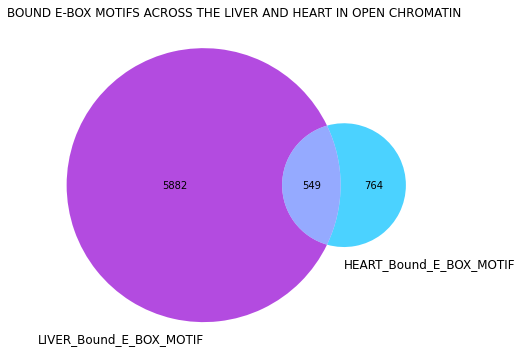

In [316]:
#overlap of bound open chromatin E-box motifs in the liver and heart 
sets = Counter()               #set order A, B  
sets['10'] = len(A-AB_overlap) #10 denotes A on, B off
sets['01'] = len(B-AB_overlap) #01 denotes A off, B on
sets['11'] = len(AB_overlap)   #11 denotes A on, B on
labels = ('LIVER_Bound_E_BOX_MOTIF', 'HEART_Bound_E_BOX_MOTIF')

plt.figure(figsize=(7,7))
ax = plt.gca()
v= venn2(subsets=sets, set_labels=labels, ax=ax,set_colors=('darkviolet','deepskyblue'),alpha=0.7)
plt.title('BOUND E-BOX MOTIFS ACROSS THE LIVER AND HEART IN OPEN CHROMATIN ')
plt.show()

### ALL BOUND

In [317]:
multi_table([Liver_Bound_E_BOX,Heart_Bound_E_BOX,Kidney_Bound_E_BOX ])

,LIVER_BOUND_EBOX
0,2725
1,9319
2,9320
3,9547
4,9548
...,...
6426,14158782
6427,14182195
6428,14182196
6429,14182197


In [318]:
A = set(Liver_Bound_E_BOX.LIVER_BOUND_EBOX)
B = set(Heart_Bound_E_BOX.HEART_BOUND_EBOX)
C = set(Kidney_Bound_E_BOX.KIDNEY_BOUND_EBOX)

AB_overlap = A & B
AC_overlap = A & C
BC_overlap = B & C
ABC_overlap = A & B & C

A_rest = A - AB_overlap 
B_rest = B - AB_overlap 
C_rest = C - AC_overlap - BC_overlap

AB_only = AB_overlap - ABC_overlap
AC_only = AC_overlap - ABC_overlap
BC_only = BC_overlap - ABC_overlap

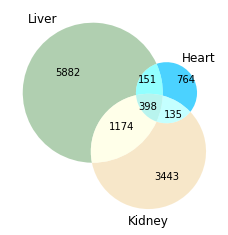

In [321]:
#overlap of bound open chromatin E-box motifs in the liver, kidney and heart 
sets = Counter()               #set order A, B, C  
sets['100'] = len(A_rest)      #100 denotes A on, B off, C off
sets['001'] = len(C_rest)      #001 denotes A off, B off, C on
sets['010'] = len(B_rest)      #010 denotes A off, B on, C off
sets['101'] = len(AC_only)     #101 denotes A on, B off, C on
sets['110'] = len(AB_only)     #110 denotes A on, B on, C off
sets['011'] = len(BC_only)     #011 denotes A off, B on, C on
sets['111'] = len(ABC_overlap) #011 denotes A on, B on, C on
labels = ('Liver', 'Heart', 'Kidney')


fig.set_size_inches(6, 5)
ax = plt.gca()
venn3(subsets=sets, set_labels=labels, ax=ax, set_colors=('darkseagreen','deepskyblue','wheat'), alpha=0.7,)   
#plt.title('BOUND E-BOX MOTIFS ACROSS ALL THREE TISSUES IN OPEN CHROMATIN ')
plt.savefig('BOUND E-BOX MOTIFS ACROSS ALL THREE TISSUES.png')
plt.show()

In [322]:
len(ABC_overlap)

398

### UNBOUND E-BOX 

In [323]:
Liver_UNBound = Un_bound_Liver['name']
Liver_UNBound = Liver_UNBound.values.tolist() 


In [324]:
Heart_UNBound = Un_Bound_Heart_Bmal['name']
Heart_UNBound  = Heart_UNBound.values.tolist() 


In [325]:
Kidney_UNBound  = Un_bound_kidney['name']
Kidney_UNBound  = Kidney_UNBound.values.tolist() 


In [326]:
Liver_UNBound_E_BOX = pd.DataFrame(Liver_UNBound,columns=['LIVER_UNBOUND_EBOX'])
Heart_UNBound_E_BOX = pd.DataFrame(Heart_UNBound,columns=['HEART_UNBOUND_EBOX'])
Kidney_UNBound_E_BOX = pd.DataFrame(Kidney_UNBound,columns=['KIDNEY_UNBOUND_EBOX'])
multi_table([Liver_UNBound_E_BOX,Kidney_UNBound_E_BOX])

,LIVER_UNBOUND_EBOX
0,2207
1,6949
2,6950
3,6951
4,6952
...,...
189576,14660249
189577,14660250
189578,14660254
189579,14660255


In [327]:
A = set(Liver_UNBound_E_BOX.LIVER_UNBOUND_EBOX)
B = set(Kidney_UNBound_E_BOX.KIDNEY_UNBOUND_EBOX)
#C = set(dfC.CNames)

AB_overlap = A & B
#AC_overlap = A & C
#BC_overlap = B & C
#ABC_overlap = A & B & C

A_rest = A - AB_overlap 
B_rest = B - AB_overlap 
#C_rest = C - AC_overlap - BC_overlap

#AB_only = AB_overlap - ABC_overlap
#AC_only = AC_overlap - ABC_overlap
#BC_only = BC_overlap - ABC_overlap

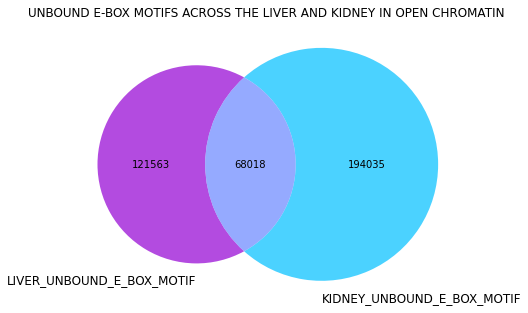

In [330]:
#overlap of unbound open chromatin E-box motifs in the liver and kidney
sets = Counter()               #set order A, B  
sets['10'] = len(A-AB_overlap) #10 denotes A on, B off
sets['01'] = len(B-AB_overlap) #01 denotes A off, B on
sets['11'] = len(AB_overlap)   #11 denotes A on, B on
labels = ('LIVER_UNBOUND_E_BOX_MOTIF', 'KIDNEY_UNBOUND_E_BOX_MOTIF')

plt.figure(figsize=(7,7))
ax = plt.gca()
v= venn2(subsets=sets, set_labels=labels, ax=ax,set_colors=('darkviolet','deepskyblue'),alpha=0.7)
plt.title('UNBOUND E-BOX MOTIFS ACROSS THE LIVER AND KIDNEY IN OPEN CHROMATIN ')
plt.show()

In [331]:
multi_table([Liver_UNBound_E_BOX,Heart_UNBound_E_BOX])

,LIVER_UNBOUND_EBOX
0,2207
1,6949
2,6950
3,6951
4,6952
...,...
189576,14660249
189577,14660250
189578,14660254
189579,14660255


In [332]:
A = set(Liver_UNBound_E_BOX.LIVER_UNBOUND_EBOX)
B = set(Heart_UNBound_E_BOX.HEART_UNBOUND_EBOX)
#C = set(dfC.CNames)

AB_overlap = A & B
#AC_overlap = A & C
#BC_overlap = B & C
#ABC_overlap = A & B & C

A_rest = A - AB_overlap 
B_rest = B - AB_overlap 
#C_rest = C - AC_overlap - BC_overlap

#AB_only = AB_overlap - ABC_overlap
#AC_only = AC_overlap - ABC_overlap
#BC_only = BC_overlap - ABC_overlap

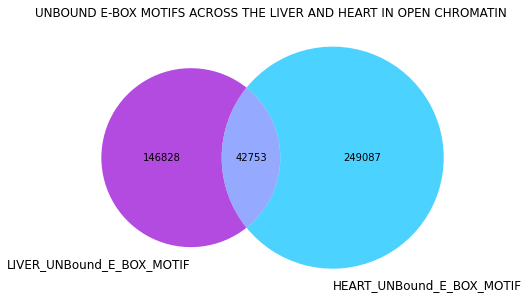

In [334]:
#overlap of unbound open chromatin E-box motifs in the liver and heart 
sets = Counter()               #set order A, B  
sets['10'] = len(A-AB_overlap) #10 denotes A on, B off
sets['01'] = len(B-AB_overlap) #01 denotes A off, B on
sets['11'] = len(AB_overlap)   #11 denotes A on, B on
labels = ('LIVER_UNBound_E_BOX_MOTIF', 'HEART_UNBound_E_BOX_MOTIF')

plt.figure(figsize=(7,7))
ax = plt.gca()
v= venn2(subsets=sets, set_labels=labels, ax=ax,set_colors=('darkviolet','deepskyblue'),alpha=0.7)
plt.title('UNBOUND E-BOX MOTIFS ACROSS THE LIVER AND HEART IN OPEN CHROMATIN ')
plt.show()

### ALL UNBOUND

In [335]:
multi_table([Liver_UNBound_E_BOX,Heart_UNBound_E_BOX,Kidney_UNBound_E_BOX ])

,LIVER_UNBOUND_EBOX
0,2207
1,6949
2,6950
3,6951
4,6952
...,...
189576,14660249
189577,14660250
189578,14660254
189579,14660255


In [336]:
A = set(Liver_UNBound_E_BOX.LIVER_UNBOUND_EBOX)
B = set(Heart_UNBound_E_BOX.HEART_UNBOUND_EBOX)
C = set(Kidney_UNBound_E_BOX.KIDNEY_UNBOUND_EBOX)

AB_overlap = A & B
AC_overlap = A & C
BC_overlap = B & C
ABC_overlap = A & B & C

A_rest = A - AB_overlap 
B_rest = B - AB_overlap 
C_rest = C - AC_overlap - BC_overlap

AB_only = AB_overlap - ABC_overlap
AC_only = AC_overlap - ABC_overlap
BC_only = BC_overlap - ABC_overlap

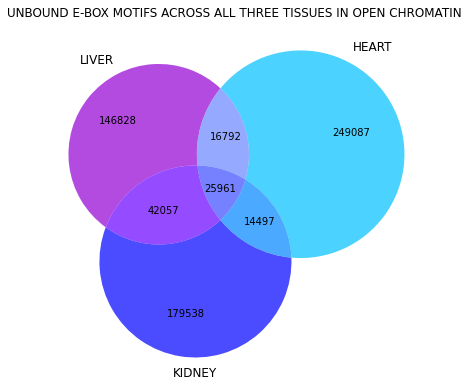

In [337]:
#overlap of unbound open chromatin E-box motifs in the liver, heart and kidney 
sets = Counter()               #set order A, B, C  
sets['100'] = len(A_rest)      #100 denotes A on, B off, C off
sets['001'] = len(C_rest)      #001 denotes A off, B off, C on
sets['010'] = len(B_rest)      #010 denotes A off, B on, C off
sets['101'] = len(AC_only)     #101 denotes A on, B off, C on
sets['110'] = len(AB_only)     #110 denotes A on, B on, C off
sets['011'] = len(BC_only)     #011 denotes A off, B on, C on
sets['111'] = len(ABC_overlap) #111 denotes A on, B on, C on
labels = ('LIVER', 'HEART', 'KIDNEY')

plt.figure(figsize=(7,7))
ax = plt.gca()
venn3(subsets=sets, set_labels=labels, ax=ax,set_colors=('darkviolet','deepskyblue','blue'),alpha=0.7) 
label.set_fontsize=40
label.fontweight='bold'
plt.title('UNBOUND E-BOX MOTIFS ACROSS ALL THREE TISSUES IN OPEN CHROMATIN ')
plt.savefig('UNBOUND_E-BOX MOTIFS ACROSS ALL THREE TISSUES.png')
plt.show()

### E-BOX BAR GRAPH FOR ALL THE GENOME

### E-BOX FOR DNASE-SEQ

In [401]:
Combine = pd.merge(pd.DataFrame(Liver_DNAse_Count), pd.DataFrame(Kidney_DNAse_Count), left_index=True, right_index=True)
Combine

,seq_x,seq_y
CAGCTG,28229,38039
CACCTG,15419,18108
CAGGTG,15395,18015
CAGATG,15072,18531
CATCTG,14899,18780
CACATG,13410,18970
CATGTG,13341,19149
CACTTG,11607,16842
CAAATG,11526,17225
CAAGTG,11342,16552


In [402]:
Tissue_DNASE = pd.merge(Combine, pd.DataFrame(Heart_DNAse_Count), left_index=True, right_index=True)
Tissue_DNASE

,seq_x,seq_y,seq
CAGCTG,28229,38039,38656
CACCTG,15419,18108,23768
CAGGTG,15395,18015,23653
CAGATG,15072,18531,22440
CATCTG,14899,18780,22823
CACATG,13410,18970,23567
CATGTG,13341,19149,23338
CACTTG,11607,16842,17023
CAAATG,11526,17225,13840
CAAGTG,11342,16552,16928


In [403]:
Tissue_DNASE.columns =['Liver', 'Kidney', 'heart']

In [404]:
Tissue_DNASE=Tissue_DNASE.reindex(GENOME_EBOX.index) 

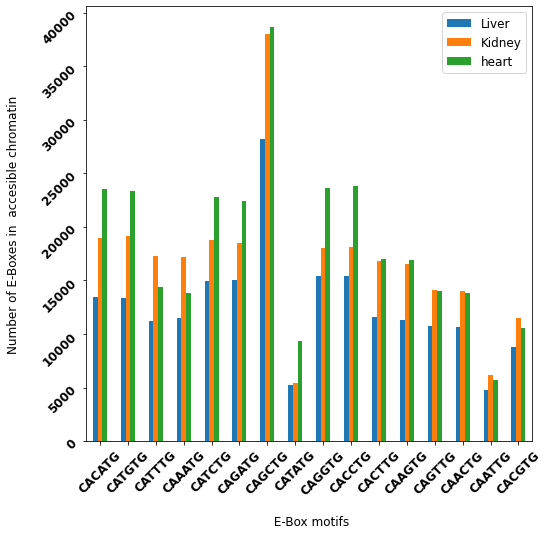

In [405]:
#Distribution of E-box binding motifs in open chromatin across the liver (blue), kidney (orange) and heart (green) using the  hexamer CANNTG.
for label in (ax.get_xticklabels() + ax.get_yticklabels()):label.set_fontsize(20)
ax = Tissue_DNASE.plot.bar(figsize=(8,8))
ax.set_xlabel(' E-Box motifs',labelpad=18,fontsize=12)
ax.set_ylabel('Number of E-Boxes in  accesible chromatin',labelpad=20, fontsize=12)
plt.xticks(fontsize=12, rotation =45,fontweight ="bold")
plt.yticks(fontsize=12,rotation=45,fontweight ="bold")
plt.legend( fontsize = 12)
plt.savefig('TISSUE DNase_E-BOXES.png')
plt.show()

In [406]:
NEW_Combine = pd.merge(pd.DataFrame(NEW_Liver_DNAse_Count), pd.DataFrame(NEW_Kidney_DNAse_Count), left_index=True, right_index=True)
NEW_Combine

,seq_x,seq_y
GC,28229,38039
CC,15419,18108
GG,15395,18015
GA,15072,18531
TC,14899,18780
CA,13410,18970
TG,13341,19149
CT,11607,16842
AA,11526,17225
AG,11342,16552


In [407]:
NEW_Tissue_DNASE = pd.merge(NEW_Combine, pd.DataFrame(NEW_Heart_DNAse_Count), left_index=True, right_index=True)
NEW_Tissue_DNASE

,seq_x,seq_y,seq
GC,28229,38039,38656
CC,15419,18108,23768
GG,15395,18015,23653
GA,15072,18531,22440
TC,14899,18780,22823
CA,13410,18970,23567
TG,13341,19149,23338
CT,11607,16842,17023
AA,11526,17225,13840
AG,11342,16552,16928


In [408]:
NEW_Tissue_DNASE.columns =['Liver', 'Kidney', 'heart']

In [409]:
NEW_Tissue_DNASE=NEW_Tissue_DNASE.reindex(NEW_GENOME_EBOX.index) 

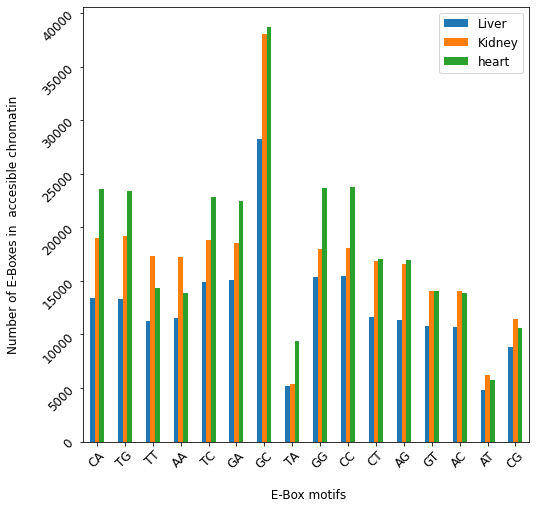

In [372]:
#Distribution of E-box binding motifs in open chromatin across the liver (blue), kidney (orange) and heart (green) using the central (NN) dimer.

for label in (ax.get_xticklabels() + ax.get_yticklabels()):label.set_fontsize(20)
ax = NEW_Tissue_DNASE.plot.bar(figsize=(8,8))
ax.set_xlabel(' E-Box motifs',labelpad=18,fontsize=12)
ax.set_ylabel('Number of E-Boxes in  accesible chromatin',labelpad=20, fontsize=12)
plt.xticks(fontsize=12, rotation =45)
plt.yticks(fontsize=12,rotation=45)
plt.legend( fontsize = 12)
plt.savefig('NEW_TISSUE DNase_E-BOXES.png')
plt.show()

### E-BOX FOR BOUND DATASET

In [410]:
NEW_Heart_BMAL1_Bound_E_BOX_PERCENTAGE =  (NEW_Heart_BMAL1_Bound_E_BOX/NEW_Heart_DNAse_Count)*100
NEW_Heart_BMAL1_Bound_E_BOX_PERCENTAGE

AA    0.093931
AC    0.209689
AG    0.242202
AT    0.280063
CA    0.356431
CC    0.378660
CG    4.785276
CT    0.334841
GA    0.160428
GC    0.475993
GG    0.321312
GT    0.192651
TA    0.095898
TC    0.192788
TG    0.381352
TT    0.076634
Name: seq, dtype: float64

In [411]:
NEW_Kidney_BMAL1_Bound_E_BOX_PERCENTAGE =  (NEW_Kidney_BMAL1_Bound_E_BOX/NEW_Kidney_DNAse_Count)*100
NEW_Kidney_BMAL1_Bound_E_BOX_PERCENTAGE

AA     0.528302
AC     0.891774
AG     0.900193
AT     0.854563
CA     2.419610
CC     2.220013
CG    14.693308
CT     1.003444
GA     0.793265
GC     1.464287
GG     2.392451
GT     0.859131
TA     0.461681
TC     0.873269
TG     2.490992
TT     0.554913
Name: seq, dtype: float64

In [412]:
NEW_Liver_BMAL1_Bound_E_BOX_PERCENTAGE =  (NEW_Liver_BMAL1_Bound_E_BOX/NEW_Liver_DNAse_Count)*100
NEW_Liver_BMAL1_Bound_E_BOX_PERCENTAGE

AA     1.405518
AC     2.087819
AG     2.336449
AT     2.056663
CA     4.347502
CC     3.404890
CG    18.483681
CT     1.955716
GA     1.459660
GC     2.497432
GG     3.364729
GT     1.970993
TA     0.841622
TC     1.671253
TG     4.572371
TT     1.416607
Name: seq, dtype: float64

In [414]:
NEW_Tissue_Bound = pd.merge(NEW_Combine, pd.DataFrame(NEW_Heart_BMAL1_Bound_E_BOX_PERCENTAGE), left_index=True, right_index=True)
NEW_Tissue_Bound.columns =['Liver', 'Kidney', 'Heart']

NEW_Tissue_Bound=NEW_Tissue_Bound.reindex(NEW_GENOME_EBOX.index) 

NEW_Tissue_Bound 

,Liver,Kidney,Heart
CA,4.347502,2.419610,0.356431
TG,4.572371,2.490992,0.381352
TT,1.416607,0.554913,0.076634
AA,1.405518,0.528302,0.093931
TC,1.671253,0.873269,0.192788
GA,1.459660,0.793265,0.160428
GC,2.497432,1.464287,0.475993
TA,0.841622,0.461681,0.095898
GG,3.364729,2.392451,0.321312
CC,3.404890,2.220013,0.378660


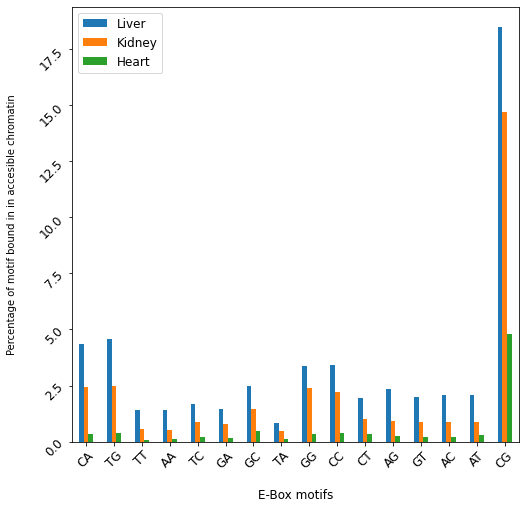

In [416]:
# Percentage of BMAL1 bound E-box motifs in open chromatin across the liver (blue), kidney (orange) and heart (green) using the central dimer (NN).  
for label in (ax.get_xticklabels() + ax.get_yticklabels()):label.set_fontsize(20)
ax = NEW_Tissue_Bound.plot.bar(figsize=(8,8))
ax.set_xlabel('E-Box motifs',labelpad=18,fontsize=12)
ax.set_ylabel('Percentage of motif bound in in accesible chromatin',labelpad=20, fontsize=10)
plt.xticks(fontsize=12, rotation =45)
plt.yticks(fontsize=12,rotation=45)
plt.legend( fontsize = 12)
plt.savefig('NEW_TISSUE Bound_E-BOXES.png')
plt.show()

In [417]:
Heart_BMAL1_Bound_E_BOX_PERCENTAGE =  (Heart_BMAL1_Bound_E_BOX/Heart_DNAse_Count)*100
Heart_BMAL1_Bound_E_BOX_PERCENTAGE

CAAATG    0.093931
CAACTG    0.209689
CAAGTG    0.242202
CAATTG    0.280063
CACATG    0.356431
CACCTG    0.378660
CACGTG    4.785276
CACTTG    0.334841
CAGATG    0.160428
CAGCTG    0.475993
CAGGTG    0.321312
CAGTTG    0.192651
CATATG    0.095898
CATCTG    0.192788
CATGTG    0.381352
CATTTG    0.076634
Name: seq, dtype: float64

In [418]:
Kidney_BMAL1_Bound_E_BOX_PERCENTAGE =  (Kidney_BMAL1_Bound_E_BOX/Kidney_DNAse_Count)*100
Kidney_BMAL1_Bound_E_BOX_PERCENTAGE

CAAATG     0.528302
CAACTG     0.891774
CAAGTG     0.900193
CAATTG     0.854563
CACATG     2.419610
CACCTG     2.220013
CACGTG    14.693308
CACTTG     1.003444
CAGATG     0.793265
CAGCTG     1.464287
CAGGTG     2.392451
CAGTTG     0.859131
CATATG     0.461681
CATCTG     0.873269
CATGTG     2.490992
CATTTG     0.554913
Name: seq, dtype: float64

In [419]:
Liver_BMAL1_Bound_E_BOX_PERCENTAGE =  (Liver_BMAL1_Bound_E_BOX/Liver_DNAse_Count)*100
Liver_BMAL1_Bound_E_BOX_PERCENTAGE

CAAATG     1.405518
CAACTG     2.087819
CAAGTG     2.336449
CAATTG     2.056663
CACATG     4.347502
CACCTG     3.404890
CACGTG    18.483681
CACTTG     1.955716
CAGATG     1.459660
CAGCTG     2.497432
CAGGTG     3.364729
CAGTTG     1.970993
CATATG     0.841622
CATCTG     1.671253
CATGTG     4.572371
CATTTG     1.416607
Name: seq, dtype: float64

In [420]:
Combine = pd.merge(pd.DataFrame(Liver_BMAL1_Bound_E_BOX_PERCENTAGE), pd.DataFrame(Kidney_BMAL1_Bound_E_BOX_PERCENTAGE), left_index=True, right_index=True)

In [421]:
Tissue_Bound = pd.merge(Combine, pd.DataFrame(Heart_BMAL1_Bound_E_BOX_PERCENTAGE), left_index=True, right_index=True)


In [422]:
Tissue_Bound.columns =['Liver', 'Kidney', 'Heart']

In [423]:
Tissue_Bound=Tissue_Bound.reindex(GENOME_EBOX.index) 

In [424]:
Tissue_Bound 

,Liver,Kidney,Heart
CACATG,4.347502,2.419610,0.356431
CATGTG,4.572371,2.490992,0.381352
CATTTG,1.416607,0.554913,0.076634
CAAATG,1.405518,0.528302,0.093931
CATCTG,1.671253,0.873269,0.192788
CAGATG,1.459660,0.793265,0.160428
CAGCTG,2.497432,1.464287,0.475993
CATATG,0.841622,0.461681,0.095898
CAGGTG,3.364729,2.392451,0.321312
CACCTG,3.404890,2.220013,0.378660


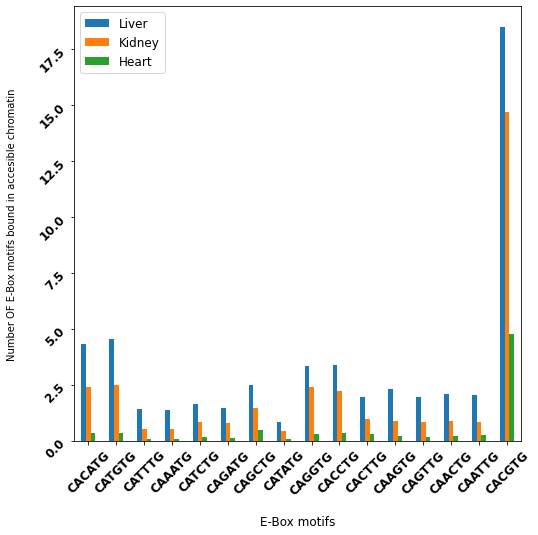

In [425]:
# Percentage of BMAL1 bound E-box motifs in open chromatin across the liver (blue), kidney (orange) and heart (green) using the central dimer (NN). 
for label in (ax.get_xticklabels() + ax.get_yticklabels()):label.set_fontsize(20)
ax = Tissue_Bound.plot.bar(figsize=(8,8))
ax.set_xlabel('E-Box motifs',labelpad=18,fontsize=12)
ax.set_ylabel('Number OF E-Box motifs bound in accesible chromatin',labelpad=20, fontsize=10)
plt.xticks(fontsize=12, rotation =45,fontweight ="bold")
plt.yticks(fontsize=12,rotation=45,fontweight ="bold")
plt.legend( fontsize = 12)
plt.savefig('TISSUE Bound_E-BOXES.png')
plt.show()

### E-BOX FOR UNBOUND DATASET

In [426]:
Heart_BMAL1_NOT_Bound_E_BOX

CAGCTG    38333
CACCTG    23602
CAGGTG    23496
CACATG    23454
CATGTG    23201
CATCTG    22724
CAGATG    22360
CACTTG    16919
CAAGTG    16835
CATTTG    14325
CAGTTG    13953
CAAATG    13808
CAACTG    13756
CACGTG    10025
CATATG     9365
CAATTG     5684
Name: seq, dtype: int64

In [427]:
Kidney_BMAL1_NOT_Bound_E_BOX

CAGCTG    37212
CATGTG    18595
CATCTG    18531
CACATG    18419
CAGATG    18301
CACCTG    17575
CAGGTG    17457
CATTTG    17138
CAAATG    17056
CACTTG    16582
CAAGTG    16307
CAGTTG    13898
CAACTG    13828
CACGTG     9671
CAATTG     6118
CATATG     5365
Name: seq, dtype: int64

In [428]:
Liver_BMAL1_NOT_Bound_E_BOX

CAGCTG    26716
CAGATG    14463
CACCTG    14354
CAGGTG    14345
CATCTG    14251
CACATG    12521
CATGTG    12461
CAAATG    11045
CACTTG    11042
CATTTG    10765
CAAGTG    10716
CAGTTG    10227
CAACTG    10159
CACGTG     6888
CATATG     5080
CAATTG     4548
Name: seq, dtype: int64

In [429]:
Combine = pd.merge(pd.DataFrame(Heart_BMAL1_NOT_Bound_E_BOX), pd.DataFrame(Kidney_BMAL1_NOT_Bound_E_BOX), left_index=True, right_index=True)

In [430]:
Tissue_UNBound = pd.merge(Combine, pd.DataFrame(Liver_BMAL1_NOT_Bound_E_BOX), left_index=True, right_index=True)


In [431]:
Tissue_UNBound.columns =['HEART', 'KIDNEY', 'LIVER']

In [432]:
Tissue_UNBound=Tissue_UNBound.reindex(GENOME_EBOX.index)

In [433]:
Tissue_UNBound 

,HEART,KIDNEY,LIVER
CACATG,23454,18419,12521
CATGTG,23201,18595,12461
CATTTG,14325,17138,10765
CAAATG,13808,17056,11045
CATCTG,22724,18531,14251
CAGATG,22360,18301,14463
CAGCTG,38333,37212,26716
CATATG,9365,5365,5080
CAGGTG,23496,17457,14345
CACCTG,23602,17575,14354


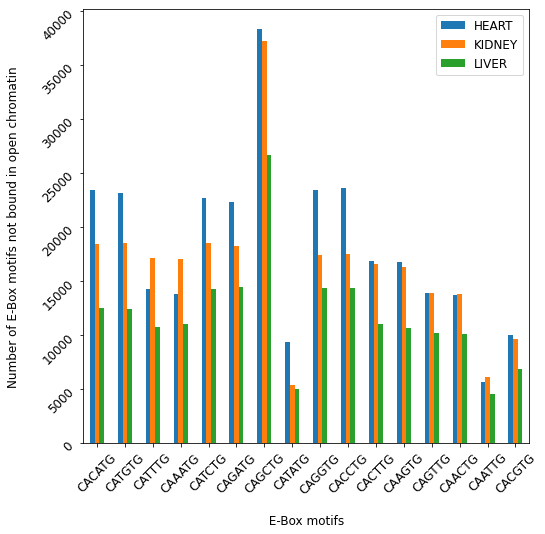

In [435]:
#Distribution of E-box binding motifs not bound in open chromatin across the liver (blue), kidney (orange) and heart (green) using the  hexamer CANNTG.

for label in (ax.get_xticklabels() + ax.get_yticklabels()):label.set_fontsize(30)
ax = Tissue_UNBound.plot.bar(figsize=(8,8))
ax.set_xlabel(' E-Box motifs ',labelpad=18,fontsize=12)
ax.set_ylabel('Number of E-Box motifs not bound in open chromatin',labelpad=20, fontsize=12)
plt.xticks(fontsize=12, rotation =45)
plt.yticks(fontsize=12,rotation=45)
plt.legend( fontsize = 12)
plt.savefig('TISSUE UNBound_E-BOXES.png')
plt.show()